In [8]:
import numpy as np
import matplotlib.pyplot as plt  # plotting

from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from scipy import ndimage  # for shifting/filtering images
from scipy.signal import savgol_filter  # for smoothing
from scipy.optimize import curve_fit   # for curve fitting 
#from scipy.optimize import minimize  # for 2d fitting
from scipy.optimize import least_squares  # for 2d fitting

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this notebook we fit crater profiles to find radii as a function of zeta azimuthal angle
and impact parameter theta_I

For Azimuthal ejecta mass paper

This routine reads in A?0_profile.npz files (from Suo+23) and ejectamass_bins.npz file
which was made in mass_ejecta2.ipynb

Figures:

* 'R_zeta.png'  crater radii measured from crater profiles 
* 'Rcr_fit.png'  fit to R_cr
* 'Rrim_fit.png' fit to R_rim
* 'Rcr_fit_Radu.png' fit to R_cr using Raducan inspired function 
* 'circs.png'  showing R_cr fits from above
* 'Mmodel2.png'  fit to mass in ejecta as a function of angles 
* 'Amplitudes.png'  showing amplitudes of crater radius and ejecta mass variations

In [2]:

#Required data to read in: from Suo+23 paper
#  A?0_profile.npz  # results of crater profile measurement

# data table of measurements from craters
theta_I = np.array([80.,70,60,50,40,30,20,10]) # deg impact angle

# distance between center of x major axis and impact point
dmx = np.array([-2.6,-3.8,-6.8,-10.5,-14.9,-11.1,-8.2,-6.3])
# center of crater is to the left of impact point, uprange is to the right +x


In [3]:
vol = np.array([13.84, 13.3, 14.6, 15.3, 13.2, 8.5, 7.0, 3.3])  #cm^3 crater volumes
# order 80 to 10 degrees in impact angle 
# all of these from previous paper Suo+24 except the 80 degree measurement which we updated
vol_CR = np.flip(vol)  # now going from 10 degres to 80 degrees 
print(vol_CR)

[ 3.3   7.    8.5  13.2  15.3  14.6  13.3  13.84]


In [4]:
# about the experiments
v_impact = 104.00  #m/s
u_pj = v_impact

rho_a = 1.5e3 # kg/m^3  substrate density
rho_pj = 1.80e3 # projectile density g/cc to kg/m^3
m_pj = 0.20e-3 # g to kg
a_pj = 2.98*1e-3  # mm to m projectile radius 
g_a = 9.8 # m/s^2
pi_2 = g_a * a_pj/u_pj**2
Y_a = 500.0 #P a
pi_3 = Y_a/(rho_a*u_pj**2)
pi_4 = rho_a/rho_pj

print('pi_2={:.2e} pi_3={:.2e} pi_4={:.2f}'.format(pi_2,pi_3,pi_4))
# confirming what is in the table!

# Crater volume as integrated from zero level
V_80 = 13.84*1e-6  # in m^-3 was 14.7 cm^-3 as taken from a Table by Suo+24
# but I measured again below and got 13.84
# and I checked original ipynb reduction file and found 14.1, none of these agree! 
# the limits for integration are slightly different in the three cases I think

#vol = 13.84 cm^3, mass 20.75 g
#vol2 = 3.37 cm^3, mass 5.05 g rim vol

R_80=  28.48*1e-3 #  mm to m and measured below, crater radius, 
# approx for R_cr,n

pi_R_80 = R_80*(rho_a/m_pj)**(1.0/3.0)
pi_V_80 = V_80*rho_a/m_pj
print('pi_R={:.2f} pi_V={:.1f} '.format(pi_R_80,pi_V_80))

mu=0.4; nu=0.4
H_1_80 =  R_80/a_pj * np.power(4*np.pi/3,-0.333333333)\
                *np.power(pi_2,mu/(2+mu)) * np.power(pi_4, 6*nu/(2+mu))
H_2_80 = R_80/a_pj * np.power(4*np.pi/3,-0.333333333)\
                *np.power(pi_3,mu/2) * np.power(pi_4, nu)

print('H_1={:.2f} H_2 = {:.2f}'.format(H_1_80,H_2_80))

print('Mass in crater volume {:.1f} (g)'.format(V_80*rho_a*1e3))

zz = V_80/R_80**3
print('V_cr/R^3 {:.2f}'.format(zz))

print (np.power(pi_3,1.2) * np.power(pi_4,0.4)/pi_2)


pi_2=2.70e-06 pi_3=3.08e-05 pi_4=0.83
pi_R=5.57 pi_V=103.8 
H_1=0.58 H_2 = 0.69
Mass in crater volume 20.8 (g)
V_cr/R^3 0.60
1.3290040990162053


$$H_1 = \left( \frac{R_{cr}}{a_{pj}}\right) \left(\frac{4\pi }{3} \right)^{-\frac{1}{3}}
\pi_2^{\frac{\mu}{\mu+2}} \pi_4^{\frac{6 \nu}{\mu+2}} 
$$
$$H_2= \left( \frac{R_{cr}}{a_{pj}}\right) \left(\frac{4\pi }{3} \right)^{-\frac{1}{3}}
\pi_3^{\frac{\mu}{2}} \pi_4^{\nu} $$

In [26]:
# read in crater profiles, from Suo+24, slope arrays and still images for each impact experiment
# inputs:  
#     filename syntax = 'A' + '{:2d}'.format(i) + '_profile.npz'   i is 10,20 .... 80
# returns:
#    xmm, x-position w.r.t. impact point in mm, is a 1d array, length nx
#    ymm, y-position w.r.t. impact point in mm, is a 1d array, length ny
#    zmm, depth in mm 2d array,  shape is ny, nx  - note order of indexing
#    slope, 2d array, same shape , degrees
#    stillim,  a photo
#  note: xmm increases, but ymm decreases 

def readnpz(filename):
    npzfile = np.load(filename)
    xmm = npzfile['xmm']
    ymm =npzfile['ymm']
    zmm = npzfile['zmm_filt']
    slope = npzfile['slope_deg']
    still_im = npzfile['still_im_short']
    return xmm,ymm,zmm,slope,still_im

colorlist = ['grey','brown', 'purple','magenta','blue','cyan','green','orange','red']
# consistent with bingcheng's starting with 10 ending with 90


In [27]:
# return depth at position xpos,ypos which are real numbers 
# does linear interpolation 
# arguments:
#  xpos,ypos position with respect to impact point in mm
#  xmm,ymm,zmm  from profile read in of file, +x is uprange, z is depth
# outputs:
#  depth at xpos,ypos linear-interpolated from 2d-image zmm
#  depth is -1000 if outside of image 
def intperp_z(xpos,ypos,xmm,ymm,zmm):
    dx = xmm[1]-xmm[0]
    dy = ymm[1]-ymm[0]
    #print('dxdy',dx,dy)
    nx = len(xmm)
    ny = len(ymm)
    #print(nx,ny)
    xmin = xmm[0]
    ymin = ymm[0]
    #print('xminymin',xmin,ymin)
    ix = int((xpos-xmin)/dx)
    iy = int((ypos-ymin)/dy)
    #print('ixiy',ix,iy)
    mux = (xpos-xmin)/dx - ix  # is zero at ix position
    muy = (ypos-ymin)/dy - iy
    #print('mux,muy',mux,muy)
    zret = -1000  # an error flag
    if (ix <0):  # out of bounds of array
        return zret
    if (iy <0):
        return zret
    if (ix >= nx-1):
        return zret
    if (iy >= ny-1):
        return zret
    zret =  (1-muy)*(1-mux) * zmm[iy  ,ix]   \
          + (1-muy)*mux     * zmm[iy  ,ix+1] \
          + muy*(1-mux)     * zmm[iy+1,ix]   \
          +  muy*mux        * zmm[iy+1,ix+1]
    return zret
    
# test, seems ok
#xpos = 0.5; ypos = 10.5
#z = intperp_z(xpos,ypos,xmm,ymm,zmm)   
#print(z)


# extract the profile at azimuthal angle zeta (0=uprange)
# use spacing dx in mm 
# zeta is in radians, angle from horizontal 
# arguments: 
#  xmm,ymm,zmm: from profile readin, in mm, 2d arrays
#  zeta: azimuthal angle in radians
#  dx: spacing of desired output
# outputs:
#  xlin: radius of output depths in mm, with spacing dx
#  zret: depth as a function of x, at the angle zeta
# the length of the array is set by the amount of data  (extent of zmm depth image)
def zeta_line(xmm,ymm,zmm,zeta,dx):
    imax = 400  # cutoff in pixels 
    xmax = imax*dx
    xlin = np.linspace(0,xmax,int(xmax/dx))
    zarr = xlin*0
    #print(xlin)
    zret =0; i=0
    while (zret >-100) and (i < imax):  #  cutoff when run out of data or i>imax
        xpos = xlin[i]*np.cos(zeta)
        ypos = xlin[i]*np.sin(zeta)
        zret = intperp_z(xpos,ypos,xmm,ymm,zmm)
        if (zret>-100):
            zarr[i] = zret
            i+= 1
            
    xlin = xlin[0:i]
    zarr = zarr[0:i]
    return xlin,zarr

# get crater radius of rim/max and zero cross as a function of azimuthal angle zeta
# arguments:
#   xmm,ymm,zmm  from profile readin
#   nk number of azimuthal angles we want (in 0 to 2 pi)
# returns:
#   zeta_arr: azimuthal angles in degrees 
#   rmax_arr: array of maximum rim peak radii from impact point as a function of zeta
#   rzero_arr: array of where radius =0 as a function of zeta
# note occasionally if crater rim is shallow, this routine fails and we correct bad points by hand later on
def get_r_zeta(xmm,ymm,zmm,nk):
    zeta=0; 
    dx =0.3  #  resolution in radius for each slice 
    #nk = 20  # how many zeta values 
    rmax_arr = np.zeros(nk)
    zeta_arr = np.zeros(nk)
    rzero_arr = np.zeros(nk)
    wlen = 11  # width of savgol filter window length (must be odd and an integer)
    #window length = wlen*dx
    # window length is 11*0.3 =3.3 mm 
    for k in range(nk):  #loop over zeta 
        zeta = (np.pi*2.0/nk) * k   # zeta value  in radians
        zeta_arr[k] = zeta*180/np.pi # in degrees
        xlin,zarr=zeta_line(xmm,ymm,zmm,zeta,dx)  # get slice 
        zarr2 = savgol_filter(zarr, wlen, 3)   # filter it, window zorder
        izmax = np.argmax(zarr2)  # find max
        rmax = xlin[izmax]
        zmax = zarr2[izmax]
        rmax_arr[k] = rmax
        i_zerocross = np.argmin(zarr2[0:izmax]**2)  #find zero crossing
        rzero = xlin[i_zerocross]
        rzero_arr[k] = rzero
        zzero = zarr2[i_zerocross] 
    return zeta_arr,rmax_arr,rzero_arr  # return rmax values and zero cross radius values along with zeta.
    #plt.plot(xlin,zarr2)
    #plt.plot(rmax,zmax,'o')
    #plt.plot(rzero,zzero,'ko')

# test
#nk = 22
#zeta_arr,rmax_arr,rzero_arr = get_r_zeta(xmm,ymm,zmm,nk)
#plt.plot(zeta_arr,rmax_arr,'o')
#plt.plot(zeta_arr,rzero_arr,'ko')


# read in all 8 files at once and fill 2d arrays for rmax_arr, rzero_arr
# indexing of 2d arrays:  i,j with i the impact angle and j the azimuthal angle, size: 8,nk
# returns:
#   zeta_arr: array of the azimuthal angles in degrees, length nk
#   rmax_2darr:  2darray of rim peak radius (from impact site) 
#   rzero_2darr: 2darray of zero cross radii (from impact size)
def fill_8():
    nk = 22
    rmax_2darr = np.zeros((8,nk))  # 8 impact angles
    rzero_2darr = np.zeros((8,nk))
    for i in range(10,81,10):
        #dx1=0
        fname = 'A' + '{:2d}'.format(i) + '_profile.npz'
        j = int(i/10)-1
        print(fname,j)
        xmm,ymm,zmm,slope,still_im = readnpz(fname)  # read in file
        #deg_str = '{:2d}'.format(i) + r'$^o$'
        if (i==10):
            ymm+=1.5  # correct y value for 10^degree 
        zeta_arr,rmax_arr,rzero_arr = get_r_zeta(xmm,ymm,zmm,nk)
        
        # cosmetic by hand corrections for the few bad points for which our zero crossing and maxes failed
        if (i==40):
            rmax_arr[1] = (rmax_arr[0] + rmax_arr[2])/2     #correct bad data point by hand
            rzero_arr[1] = (rzero_arr[0] + rzero_arr[2])/2  #correct bad data point by hand
        
        if (i==10):
            rmax_arr[1] = 16.3; rmax_arr[0] = 15.5  # correct 2 bad data points by hand
            rzero_arr[1] = 14.5; rzero_arr[0] = 14.2
        
        rmax_2darr[j,:] =rmax_arr 
        rzero_2darr[j,:] =rzero_arr 
        
    return zeta_arr,rmax_2darr,rzero_2darr

# returned are the resulting radii (measured)

zeta_arr,rmax_2darr,rzero_2darr = fill_8()  # fill 2d arrays of measured radii
# here is where zeta and theta 2d arrays  are created! 
zeta_rad = zeta_arr*np.pi/180.  # azimuthal radii in radians (1d)
theta_deg = np.arange(1,9)*10.0   # impact angles in degrees  (1d)
theta_rad = theta_deg*np.pi/180.  # impact angles in radians (1d)
zeta_mesh,theta_mesh = np.meshgrid(zeta_rad,theta_rad) # 2d azimuthal and impact angles, radians
#print(theta_mesh.shape)
zeta_mesh_deg  =  zeta_mesh*180/np.pi # 2d azimuthal and impact angles, degrees 
theta_mesh_deg = theta_mesh*180/np.pi

# for table 1  maybe?
rm_80 = np.mean(rmax_2darr[7,:])
rz_80 = np.mean(rzero_2darr[7,:])
print('Drim(80)={:.2f}mm, rzero(80)={:.2f} mm'.format(rm_80*2,rz_80))
print('Rrim/Rzero={:.2f}'.format(rm_80/rz_80))  # is a bit lower than the 1.3 quoted by Housen+11

A10_profile.npz 0
A20_profile.npz 1
A30_profile.npz 2
A40_profile.npz 3
A50_profile.npz 4
A60_profile.npz 5
A70_profile.npz 6
A80_profile.npz 7
Drim(80)=68.54mm, rzero(80)=28.48 mm
Rrim/Rzero=1.20


A10_profile.npz 0
A20_profile.npz 1
A30_profile.npz 2
A40_profile.npz 3
A50_profile.npz 4
A60_profile.npz 5
A70_profile.npz 6
A80_profile.npz 7
median rzero at 80^o 28.4 mm
median rmax at 80^o 33.7 mm


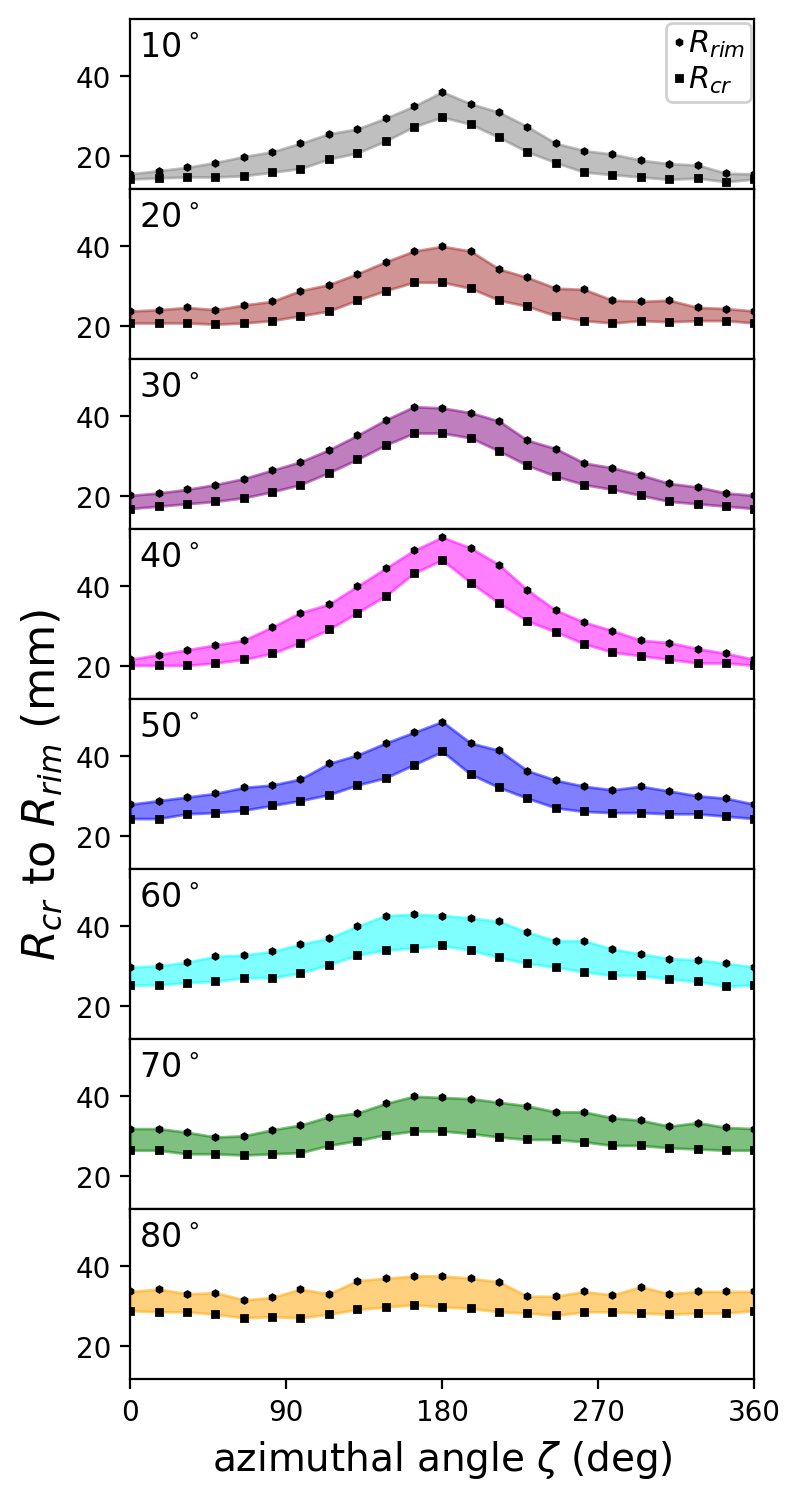

In [9]:
plot_fits=0 # do we want to plot fits or not?, the answer is no

# not important functions anymore 
# fitting functions for the coeffs
def myfun(zeta_rad,A0,a1,a2,a3):
    return A0*(1 + a1*np.cos(zeta_rad) + a2*np.cos(2*zeta_rad)+ a3*np.cos(3*zeta_rad))

def myfun2(zeta_rad,A0,A1,A2,A3):
    return A0 + A1*np.cos(zeta_rad) + A2*np.cos(2*zeta_rad)+ A3*np.cos(3*zeta_rad)


# create a figure showing radii of crater rim and zero cross as a function of zeta
# at 8 different impact angles 
# at the same time do fits, and show results of fits, save coefficients for additional fitting! 

fig,axarr = plt.subplots(8,1,figsize=(4,8),dpi=200, facecolor='white',sharex=True,sharey=True)
plt.subplots_adjust(bottom=0.13,top=0.98,right=0.96,left=0.18,wspace=0,hspace=0.0)
axarr[0].set_xlim([0,360])
nk=22  # number of azimuthal angles 
rzero_fits = np.zeros((8,4))
rmax_fits = np.zeros((8,4))
for i in range(10,81,10):
    #dx1=0
    fname = 'A' + '{:2d}'.format(i) + '_profile.npz'
    j = int(i/10)-1
    print(fname,j)
    xmm,ymm,zmm,slope,still_im = readnpz(fname)
    deg_str = '{:2d}'.format(i) + r'$^o$'
    if (i==10):
        ymm+=1.5  # correct y value for 10 degree 
    zeta_arr,rmax_arr,rzero_arr = get_r_zeta(xmm,ymm,zmm,nk)  # find radii 
    if (i==40):
        rmax_arr[1] = (rmax_arr[0] + rmax_arr[2])/2  #correct one bad data point
        rzero_arr[1] = (rzero_arr[0] + rzero_arr[2])/2  #correct one bad data point
        
    if (i==10):
        rmax_arr[1] = 16.3; rmax_arr[0] = 15.5
        rzero_arr[1] = 14.5; rzero_arr[0] = 14.2
    
    zeta_rad = zeta_arr*np.pi/180  # in radians
    zeta_rad_l = np.append(zeta_rad,2*np.pi)  #extend zeta_rad, cosmetic for plotting
    zeta_arr_l = np.append(zeta_arr,360) # extend angle (cosmetic for plotting to 360)
    
    if (i==80):
        print('median rzero at 80^o {:.1f} mm'.format(np.median(rzero_arr)))
        print('median rmax at 80^o {:.1f} mm'.format(np.median(rmax_arr)))
    
    #popt,  pcov  = curve_fit(myfun, zeta_rad, rzero_arr, p0=[10,-5,-0.1,0.1])
    #popt2, pcov2 = curve_fit(myfun, zeta_rad, rmax_arr , p0=[10,-5,-0.1,0.1])
    
    if (plot_fits==1):
        popt,  pcov  = curve_fit(myfun2, zeta_rad, rzero_arr, p0=[20,-5,-0.1,0.1])
        popt2, pcov2 = curve_fit(myfun2, zeta_rad, rmax_arr , p0=[20,-5,-0.1,0.1])
    
        #print(popt)
        rzero_fits[j,:] = popt  # store results of fit 
        rmax_fits[j,:] = popt2  # store results of fit
    
        reval  = myfun2(zeta_rad_l,*popt)  # evaluate function 
        reval2 = myfun2(zeta_rad_l,*popt2)
    
    rzero_arr_l = np.append(rzero_arr,rzero_arr[0]) # extend radii 
    rmax_arr_l = np.append(rmax_arr,rmax_arr[0])
    
    # plot results as a fill 
    axarr[j].fill_between(zeta_arr_l,rzero_arr_l,rmax_arr_l,color=colorlist[j],alpha=0.5) # label=deg_str,
    
    axarr[j].plot(zeta_arr_l, rmax_arr_l,'kh',ms=2,label=r'$R_{rim}$')
    axarr[j].plot(zeta_arr_l, rzero_arr_l,'ks',ms=2,label=r'$R_{cr}$')
    
    if (plot_fits==1):
        axarr[j].plot(zeta_arr_l,reval,'k:') # plot fits
        axarr[j].plot(zeta_arr_l,reval2,'b--')
    
    axarr[j].text(5,45,fname[1:3]+r'$^\circ$',color='black',fontsize=12)  # label theta_I on top left
    
axarr[0].legend(loc='best',borderpad=0.2,handlelength=0.4,handletextpad=0.1,columnspacing=1,labelspacing=0.15\
               ,framealpha=0.9,borderaxespad=0.1,fontsize=11)
    
axarr[7].set_xlabel(r'azimuthal angle $\zeta$ (deg)',fontsize=14)
axarr[4].set_ylabel(r'$R_{cr}$ to $R_{rim}$ (mm)',fontsize=16)
axarr[0].xaxis.set_ticks([0,90,180,270,360],['0','90','180','270','360'])

plt.savefig('R_zeta.png',dpi=200)
#This figure goes into the paper!
#rm_80 = np.median(rmax)

In [10]:
# checking up on mass estimates 
k = 0.3
M_ej = k*rho_a*R_80**3  # total ejecta mass 
print('M_ej={:.2f} g'.format(M_ej*1e3))
# this is a lot larger than our measured values of ejecta. 
# and it's a lot smaller than our crater volume!


M_ej=10.40 g


In [28]:
# coefficients in x, same units as radii (mm)

# fitting function, not used! zeta, theta in radians
def Rmod_fun2(x,theta,zeta):
    i = 0
    zz = x[i];                                  i = i+1;   # 0          
    zz += x[i]*theta;                           i = i+1;   # 1
    zz += x[i]*theta**2;                        i = i+1;   # 2
    zz += x[i]*theta   *np.cos(zeta);           i = i+1;   # 3
    zz += x[i]*theta**2*np.cos(zeta);           i = i+1;   # 4
    zz += x[i]*theta*   np.cos(2*zeta);         i = i+1;   # 5
    zz += x[i]*theta**2*np.cos(2*zeta);         i = i+1;   # 6
    
    return zz 


# fitting function, used! zeta, theta in radians
def Rmod_fun3(x,theta,zeta):
    i = 0
    zz = x[i];                                   i = i+1;   # 0  
    ctheta = np.pi/2 - theta; 
    zz += x[i]*ctheta;                           i = i+1;   # 1
    zz += x[i]*ctheta**2;                        i = i+1;   # 2
    zz += x[i]*ctheta   *np.cos(zeta);           i = i+1;   # 3
    zz += x[i]*ctheta**2*np.cos(zeta);           i = i+1;   # 4
    zz += x[i]*ctheta*   np.cos(2*zeta);         i = i+1;   # 5
    #zz += x[i]*ctheta**2*np.cos(2*zeta);            i = i+1;   # 6
    
    return zz 

# Raducan's function , only two coefficients 
def Rmod_Radu(x,theta,zeta):
    i = 0
    zz = x[i];                            i = i+1;   # 0 
    ctheta = np.pi/2 - theta; 
    zz += x[i]*ctheta   *np.cos(zeta);    i = i+1;   # 1 
    return zz

# compute vector of residuals  
# theta_mesh,zeta_mesh are 2d arrays, angles in in radians
def res_fun(x,Rmesh,theta_mesh,zeta_mesh,fit_function):
    Rmod = fit_function(x,theta_mesh,zeta_mesh)
    diff = Rmesh - Rmod 
    return diff.ravel()

# carry out minimization with this function, 
#   we are no longer using a minimization routine, 
# we are using a least_squares fitting routine
def min_fun(x,Rmesh,theta_mesh,zeta_mesh,fit_function):
    Rmod = fit_function(x,theta_mesh,zeta_mesh)
    diff2 = (Rmesh-Rmod)**2
    ones = diff2*0 + 1.0
    minz = np.sum(diff2)/np.sum(ones) # thing to minimize;  average diff^2
    minz = np.sqrt(minz)  # std of diff
    return minz

# take output of fitting result and make a model 2d array
# here x is array of parameters, theta,zeta in radians
# this would work on a different dimension of zeta,theta
def mkmodel(x,theta_mesh,zeta_mesh,fit_function):
    return fit_function(x,theta_mesh,zeta_mesh)
    


In [29]:
# for making a nice figure showing result of 2d least square fitting to crater radii
def fig_compare(zeta_mesh_deg,theta_mesh_deg,Rdata,Rmod,rtype,fig_label,ofile):
    fig,axarr = plt.subplots(3,1,figsize=(4,4),dpi=150,facecolor='white')
    plt.subplots_adjust(hspace=0,wspace=0,right=0.96,left=0.20,top=0.98,bottom=0.15)
    
    min1 = np.min(Rdata); min2 = np.min(Rmod)
    max1 = np.max(Rdata); max2 = np.max(Rmod)
    vmax = max(max1,max2); vmin =  min(min1,min2)
    if (rtype==0):
        ccolor = 'white'
        rlabel = r'$R_{rc}$ (mm)'
        #fig_label = 'a)'
        axarr[1].text(0,70,r'$R_{rc}$',color='white')
    if (rtype==1):
        ccolor = 'red'
        rlabel = r'$R_{rim}$ (mm)'
        #fig_label = 'b)'
        axarr[1].text(0,70,r'$R_{rim}$',color='red')
    if (fig_label == 'a)'):
        axarr[0].text(0,75,'model',color='white')
    if (fig_label == 'b)'):
        axarr[0].text(0,75,'model',color='red')
    if (fig_label == 'c)'):
        axarr[0].text(0,75,'R22 model',color='white')
        
    axarr[2].text(0,75,'residuals',color='black')
        
    mylevs = np.arange(10,100,10)
    
    im1=axarr[0].pcolormesh(zeta_mesh_deg,theta_mesh_deg,Rmod,vmin=vmin,vmax=vmax)
    CS1 =axarr[0].contour(zeta_mesh_deg,theta_mesh_deg,Rmod, levels=mylevs,colors=ccolor)
    cbar1=plt.colorbar(im1,label='model (mm)')
    cbar1.add_lines(CS1)
    
    im2=axarr[1].pcolormesh(zeta_mesh_deg,theta_mesh_deg,Rdata,vmin=vmin,vmax=vmax)
    cbar2=plt.colorbar(im2,label=rlabel)
    CS2=axarr[1].contour(zeta_mesh_deg,theta_mesh_deg,Rdata, levels=mylevs,colors=ccolor)
    cbar2.add_lines(CS2)

    diff = Rmod-Rdata
    mm = np.max(np.abs(diff))

    sig = np.std(diff)
    print('std = {:.2f} (mm)'.format(sig))
    im=axarr[2].pcolormesh(zeta_mesh_deg,theta_mesh_deg,diff,cmap='seismic',vmin=-mm,vmax=mm)
    plt.colorbar(im,label='diff (mm)')

    axarr[2].set_xlabel(r'azimuthal angle $\zeta$ (deg)')
    axarr[2].set_ylabel(r'impact angle $\theta_I$ (deg)')
    
    axarr[0].text(-90,75,fig_label,fontsize=16)
    
    
    if (len(ofile)>2):
        plt.savefig(ofile,dpi=200)
        

# returns an array of standard deviations (one for each parameter fit) 
#  from output of least squares fit
def std_parms(res):
    J = res.jac  # Jacobian matrix 
    #cov = np.linalg.inv(J.T.dot(J))  # compute covariance matrix 
    reduced_chi2 = (res.fun.T @ res.fun )/(res.fun.size - res.x.size)
    std_arr = np.sqrt(np.diagonal(np.linalg.inv(J.T@J))*reduced_chi2)
    scatter = np.std(res.fun.ravel() )
    return std_arr,reduced_chi2,scatter

# print parameters and standard deviations along with reduced chi^2 of fit
def print_parms(res):
    std_arr,reduced_chi2,scatter = std_parms(res)
    nx = res.x.size
    for i in range(nx):
        pstring = '${:.2f} \\pm {:.2f}$ &'.format(res.x[i],std_arr[i])
        print(pstring)
    print('sqrt red chi^2 {:.2f} red chi2 {:.2f}'.format(np.sqrt(reduced_chi2),reduced_chi2))
    print('scatter {:.2f}'.format(scatter))
    
    
# info on fitting 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

$26.12 \pm 0.58$ &
$12.28 \pm 1.70$ &
$-12.47 \pm 1.05$ &
$-13.64 \pm 0.95$ &
$6.56 \pm 0.83$ &
$2.43 \pm 0.24$ &
sqrt red chi^2 1.95 red chi2 3.81
scatter 1.92
std = 1.92 (mm)


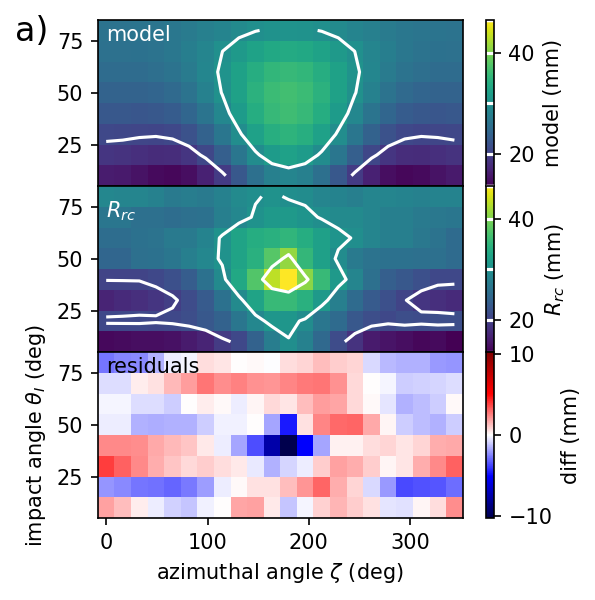

In [30]:
# fit crossing radii
x0= np.zeros(6)  # must be the right length to be consistent with fitting function 
x0[0] = 10.  # set one parameter to be nonzero
#res_zero=minimize(min_fun,x0,args=(rzero_2darr,theta_mesh,zeta_mesh,Rmod_fun2))
#print(res_zero.message,res_zero.x,res_zero.fun)
#Rmod_zero = mkmodel(res_zero.x,theta_mesh,zeta_mesh,Rmod_fun2)

# do least squares fitting to data 
res_zero=least_squares(res_fun,x0,args=(rzero_2darr,theta_mesh,zeta_mesh,Rmod_fun3))
Rmod_zero = mkmodel(res_zero.x,theta_mesh,zeta_mesh,Rmod_fun3) # create model from fit 
#std_arr,red_chi2 = std_parms(res_zero)
print_parms(res_zero)  # print table of results of fit 

# now make a nice figure 
rtype = 0 # which radius is being plotted
ofile='Rcr_fit.png'
fig_compare(zeta_mesh_deg,theta_mesh_deg,rzero_2darr,Rmod_zero,rtype,'a)',ofile)

# figure going into paper!

$32.11 \pm 0.60$ &
$13.76 \pm 1.74$ &
$-14.19 \pm 1.08$ &
$-18.24 \pm 0.98$ &
$8.89 \pm 0.86$ &
$2.09 \pm 0.24$ &
sqrt red chi^2 2.01 red chi2 4.03
scatter 1.97
std = 1.97 (mm)


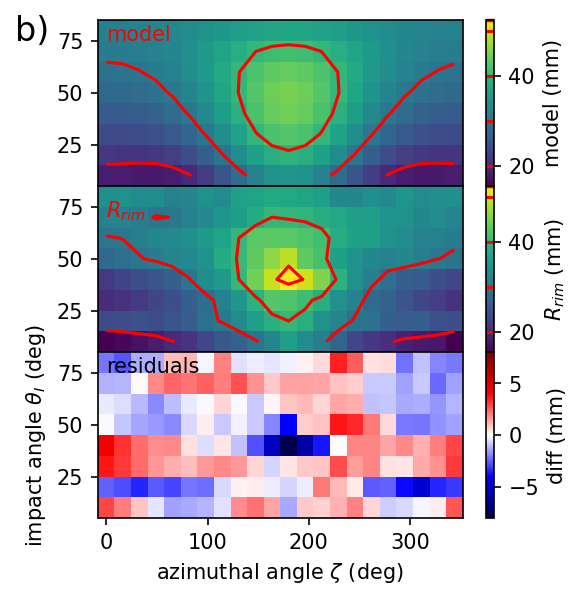

In [31]:
# fit rim radii
res_max=least_squares(res_fun,x0,args=(rmax_2darr,theta_mesh,zeta_mesh,Rmod_fun3))
Rmod_max  = mkmodel(res_max.x,theta_mesh,zeta_mesh,Rmod_fun3) # model from fit 
print_parms(res_max)  # print a table of fit results 

# and make a figure of results 
ofile='Rrim_fit.png'; 
rtype = 1 # which radius is being plotted
fig_compare(zeta_mesh_deg,theta_mesh_deg,rmax_2darr,Rmod_max,rtype,'b)',ofile)

# figure going into paper!

In [32]:
# for a table for the paper of the fit results!
# print parameters and standard deviations for two fits along with reduced chi^2 of fits
def print_parms_bi(res,resb):
    std_arr,reduced_chi2,scatter = std_parms(res)
    std_arrb,reduced_chi2b,scatterb = std_parms(resb)
    nx = res.x.size
    lstring=''
    for i in range(nx):
        if (i == 0):
            lstring = r'$a_{00}$ '
        if (i == 1):
            lstring = r'$a_{10}$ '
        if (i == 2):
            lstring = r'$a_{20}$ '
        if (i == 3):
            lstring = r'$a_{11}$ '
        if (i == 4):
            lstring = r'$a_{21}$ '
        if (i == 5):
            lstring = r'$a_{12}$ '
        pstring = '& ${:6.2f} \\pm {:4.2f}$ & ${:6.2f} \\pm {:4.2f}$ \\\\ '.format(\
                    res.x[i],std_arr[i],resb.x[i],std_arrb[i])
        print(lstring+pstring)
    #print('sqrt red_chi^2 {:.2f} red_chi2 {:.2f} sqrt red_chi^2 {:.2f} red_chi2 {:.2f}'.format(\
    #            np.sqrt(reduced_chi2),reduced_chi2,np.sqrt(reduced_chi2b),reduced_chi2b))
    print('\\hline')
    print('std residuals {:.2f} & {:.2f} \\\\'.format(scatter,scatterb))

print_parms_bi(res_zero,res_max) # print table for paper
# units are mm for these coefficients 
# going into table! 

$a_{00}$ & $ 26.12 \pm 0.58$ & $ 32.11 \pm 0.60$ \\ 
$a_{10}$ & $ 12.28 \pm 1.70$ & $ 13.76 \pm 1.74$ \\ 
$a_{20}$ & $-12.47 \pm 1.05$ & $-14.19 \pm 1.08$ \\ 
$a_{11}$ & $-13.64 \pm 0.95$ & $-18.24 \pm 0.98$ \\ 
$a_{21}$ & $  6.56 \pm 0.83$ & $  8.89 \pm 0.86$ \\ 
$a_{12}$ & $  2.43 \pm 0.24$ & $  2.09 \pm 0.24$ \\ 
\hline
std residuals 1.92 & 1.97 \\


$26.07 \pm 0.33$ &
$-6.36 \pm 0.53$ &
sqrt red chi^2 4.37 red chi2 19.12
scatter 4.35
ratio -0.24 Radu_ratio -0.29
std residuals 4.35
std = 4.35 (mm)


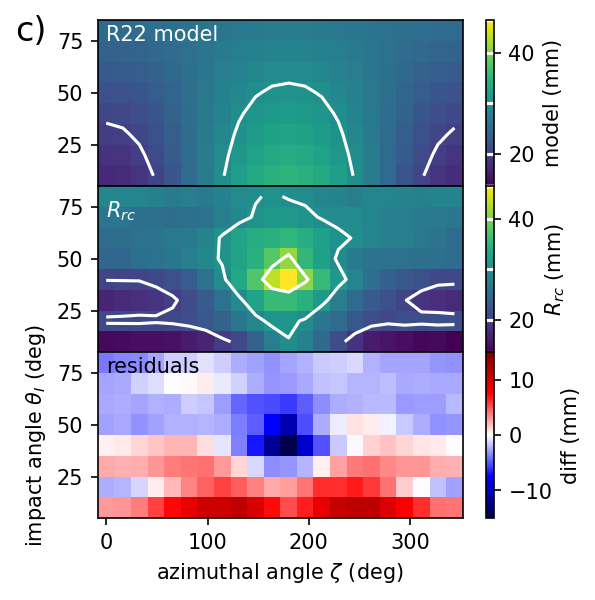

In [16]:
# fitting crossing radii with 2 coefficient model 
x0= np.zeros(2)  # must be the right length to be consistent with fitting function 
x0[0] = 10.  # set one parameter to be nonzero
#res_zero=minimize(min_fun,x0,args=(rzero_2darr,theta_mesh,zeta_mesh,Rmod_fun2))
#print(res_zero.message,res_zero.x,res_zero.fun)
#Rmod_zero = mkmodel(res_zero.x,theta_mesh,zeta_mesh,Rmod_fun2)

# do least squares fitting to data 
res_zero_Radu=least_squares(res_fun,x0,args=(rzero_2darr,theta_mesh,zeta_mesh,Rmod_Radu))
Rmod_zero_Radu = mkmodel(res_zero_Radu.x,theta_mesh,zeta_mesh,Rmod_Radu) # create model from fit 
#std_arr,red_chi2 = std_parms(res_zero)
print_parms(res_zero_Radu)  # print table of results of fit
aratio = res_zero_Radu.x[1]/res_zero_Radu.x[0]
Radu_ratio = -0.5*(1.0/100.0)*(180.0/np.pi)  # raducan function 
print('ratio {:.2f} Radu_ratio {:.2f}'.format(aratio,Radu_ratio))
std_arr,reduced_chi2,scatter = std_parms(res_zero_Radu)
print('std residuals {:.2f}'.format(scatter))

# now make a nice figure 
rtype = 0 # which radius is being plotted
ofile='Rcr_fit_Radu.png'
fig_compare(zeta_mesh_deg,theta_mesh_deg,rzero_2darr,Rmod_zero_Radu,rtype,'c)',ofile)


# going into paper, and you need to grab coefficients here
# and add them to table !

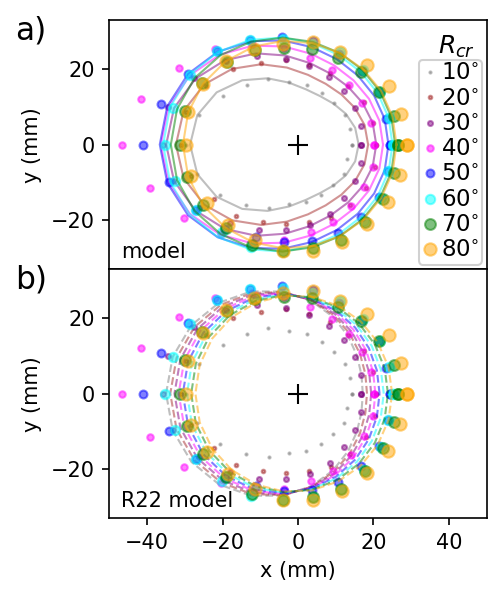

In [17]:
# make a figure showing crater radii 
nth = theta_mesh.shape[0]
nze = theta_mesh.shape[1]
x_rc = rzero_2darr*np.cos(zeta_mesh)
y_rc = rzero_2darr*np.sin(zeta_mesh)
x_rm = rmax_2darr*np.cos(zeta_mesh)
y_rm = rmax_2darr*np.sin(zeta_mesh)
xmod_rc = Rmod_zero*np.cos(zeta_mesh)
ymod_rc = Rmod_zero*np.sin(zeta_mesh)
xmod_rm = Rmod_max*np.cos(zeta_mesh)
ymod_rm = Rmod_max*np.sin(zeta_mesh)
xRadu = Rmod_zero_Radu*np.cos(zeta_mesh)
yRadu = Rmod_zero_Radu*np.sin(zeta_mesh)
fig,axarr = plt.subplots(2,1,figsize=(4,4),dpi=150,facecolor='white',\
                         sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0,right=0.98,left=0.16,top=0.98,bottom=0.15)
axarr[0].set_aspect('equal')
axarr[1].set_aspect('equal')

axarr[0].plot([0],[0],'k+',ms=10)
axarr[1].plot([0],[0],'k+',ms=10)
axarr[0].set_xlim([-50,50])
axarr[0].set_ylim([-33,33])
axarr[1].set_xlabel('x (mm)')
axarr[0].set_ylabel('y (mm)')
axarr[1].set_ylabel('y (mm)')
    
for j in range(0,nth):
    xp = np.append(x_rc[j,:],x_rc[j,0])
    yp = np.append(y_rc[j,:],y_rc[j,0])
    xm = np.append(xmod_rc[j,:],xmod_rc[j,0])
    ym = np.append(ymod_rc[j,:],ymod_rc[j,0])
    xRu = np.append(xRadu[j,:],xRadu[j,0])
    yRu = np.append(yRadu[j,:],yRadu[j,0])
    jlab = '{:2d}'.format(j*10+10) + r'$\!^\circ$'
    axarr[0].plot(xm,ym,'-',color=colorlist[j],alpha=0.5,lw=1)
    axarr[1].plot(xRu,yRu,'--',color=colorlist[j],alpha=0.5,lw=1)
 
    axarr[0].plot(xp,yp,'o',color=colorlist[j],ms=0.7*j+1,label=jlab,alpha=0.5)
    axarr[1].plot(xp,yp,'o',color=colorlist[j],ms=0.7*j+1,alpha=0.5)
    
#for j in range(nth):
#    yl = -28 + j*2 
#    axarr[0].plot([-47,-43],[yl,yl],'-',color=colorlist[j])
axarr[0].text(-47,-30,r'model')
axarr[1].text(-47,-30,r'R22 model')
axarr[0].text(-75,28,'a)',fontsize=15)
axarr[1].text(-75,28,'b)',fontsize=15)
 
axarr[0].text(37,24,r'$R_{cr}$',fontsize=12)
axarr[0].legend(loc='lower right',borderpad=0.1,handlelength=0.8,handletextpad=0.1,columnspacing=1,labelspacing=0.10\
               ,framealpha=0.9,borderaxespad=0.2,fontsize=11)

fig.savefig('circs.png',dpi=300)
# put in paper!

In [33]:
# read in output of routine mass_ejecta2.ipynb (Sean's new data! April '24)
def readnpz_mass(filename):
    npzfile = np.load(filename)
    aves_arr=npzfile['aves_arr']
    sigs_arr=npzfile['sigs_arr']
    theta_mesh=npzfile['theta_mesh']
    zeta_mesh=npzfile['zeta_mesh']
    mass_mean_arr = npzfile['mass_mean_arr']
    mass_sig_arr = npzfile['mass_sig_arr']
    return aves_arr,sigs_arr,theta_mesh,zeta_mesh,mass_mean_arr,mass_sig_arr

# read in the table from Sean's new data! 
Maves_arr,Msigs_arr,mtheta_mesh,mzeta_mesh,mass_mean_arr,mass_sig_arr = readnpz_mass("ejectamass_bins.npz")
# note theta,zeta are in radians, masses are in g

dzeta = mzeta_mesh[0,1] - mzeta_mesh[0,0]

In [34]:
nzeta = Maves_arr.shape[1]
nang  = Maves_arr.shape[0]
#print(Maves_arr.shape)
print(r'$\theta_I/\zeta$ & 0 & 45 & 90 & 135 & 180 & 225 & 270 & 315  \\')
print('\hline')
for i in range(nang-1,-1,-1):
    sstring = '{:.0f}'.format(mtheta_mesh[i,0]*180/np.pi)
    for j in range(nzeta):
        sstring += '& {:.2f}$\pm${:.2f}'.format(Maves_arr[i,j],Msigs_arr[i,j])
    print(sstring + ' \\\\')
print('\hline')
# for a table in the paper!
print('')
for i in range(nang-1,-1,-1):
    sstring = '{:.0f} '.format(mtheta_mesh[i,0]*180/np.pi)
    sstring += '& {:.2f} $\pm$ {:.2f}'.format(mass_mean_arr[i],mass_sig_arr[i])
    print(sstring + ' \\\\')

$\theta_I/\zeta$ & 0 & 45 & 90 & 135 & 180 & 225 & 270 & 315  \\
\hline
20& 0.10$\pm$0.14& 0.16$\pm$0.18& 0.32$\pm$0.33& 0.35$\pm$0.22& 0.26$\pm$0.21& 0.45$\pm$0.29& 0.41$\pm$0.29& 0.20$\pm$0.29 \\
30& 0.13$\pm$0.08& 0.23$\pm$0.13& 0.47$\pm$0.13& 0.70$\pm$0.17& 0.85$\pm$0.27& 0.64$\pm$0.19& 0.46$\pm$0.14& 0.33$\pm$0.15 \\
40& 0.05$\pm$0.05& 0.19$\pm$0.11& 0.65$\pm$0.14& 1.37$\pm$0.21& 1.81$\pm$0.23& 1.49$\pm$0.31& 1.05$\pm$0.31& 0.28$\pm$0.12 \\
50& 0.23$\pm$0.18& 0.35$\pm$0.18& 0.63$\pm$0.25& 1.24$\pm$0.27& 1.05$\pm$0.19& 1.76$\pm$0.38& 0.95$\pm$0.30& 0.35$\pm$0.12 \\
60& 0.24$\pm$0.19& 0.34$\pm$0.22& 0.60$\pm$0.15& 1.34$\pm$0.32& 1.67$\pm$0.54& 1.35$\pm$0.45& 0.67$\pm$0.20& 0.42$\pm$0.32 \\
70& 0.30$\pm$0.07& 0.40$\pm$0.15& 0.76$\pm$0.20& 1.22$\pm$0.11& 1.72$\pm$0.26& 1.61$\pm$0.25& 0.93$\pm$0.30& 0.40$\pm$0.12 \\
80& 0.42$\pm$0.11& 0.71$\pm$0.31& 1.01$\pm$0.35& 1.29$\pm$0.49& 1.40$\pm$0.34& 0.98$\pm$0.17& 0.78$\pm$0.26& 0.52$\pm$0.07 \\
\hline

20 & 2.27 $\pm$ 0.93 \\
30 & 3.81 $\pm

In [35]:
# a placer for k(theta,zeta)
# theta,zeta in radians, returns mass (unitless) per radian bin size 
def k_fun(y,theta,zeta):
    return y[0] + y[1]*np.cos(theta)*np.cos(zeta)

#make mass model 
# here x_Rfun is a fit for Radius
# Rmodfun is a function fitting radius
# dzeta in radians is bin width
# note that rho_a is currently global!!!!
def mkMmod(y,theta_mesh,zeta_mesh,x_Rfun,Rmodfun,kfun,dzeta):
    Rmod_bins  = mkmodel(x_Rfun,theta_mesh,zeta_mesh,Rmodfun)
    Mmod_bins = dzeta/(2*np.pi)*kfun(y,theta_mesh,zeta_mesh)\
            *(Rmod_bins*1e-3)**3 *rho_a*1e3  #in g now
    return Mmod_bins

# compute vector of residuals  
def res_mass_fun(y,Mdata,theta_mesh,zeta_mesh,x_Rfun,Rmodfun,k_fun,dzeta):
    Mmod = mkMmod(y,theta_mesh,zeta_mesh,x_Rfun,Rmodfun,k_fun,dzeta)
    diff = Mdata - Mmod 
    return diff.ravel()

y0 = np.array([0.1,0.02])  # initial try for fit
# carry out fit, uses Maves_arr
res_mass=least_squares(res_mass_fun,y0,args=(Maves_arr,mtheta_mesh,mzeta_mesh,\
                    res_zero.x,Rmod_fun3,k_fun,dzeta))


Mmod = mkMmod(res_mass.x,mtheta_mesh,mzeta_mesh,res_zero.x,Rmod_fun3,k_fun,dzeta)

print_parms(res_mass)

$0.19 \pm 0.01$ &
$0.02 \pm 0.02$ &
sqrt red chi^2 0.29 red chi2 0.08
scatter 0.28


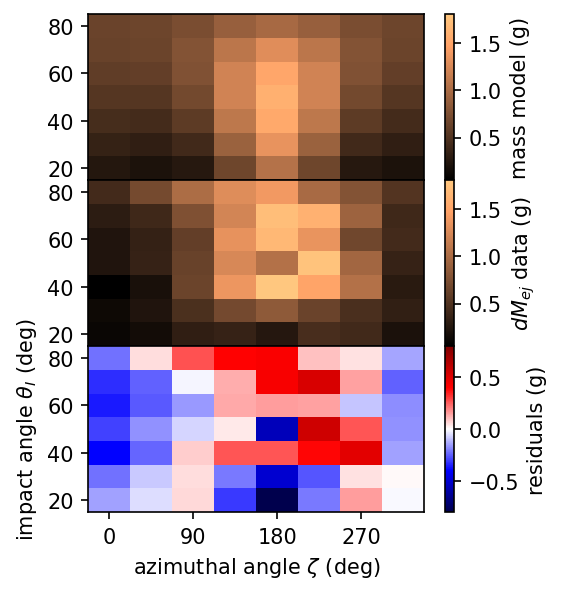

In [36]:
# make a mass ejecta model fit figure 
fig,axarr = plt.subplots(3,1,figsize=(4,4),dpi=150,facecolor='white')
plt.subplots_adjust(hspace=0,wspace=0,right=0.90,left=0.20,top=0.98,bottom=0.15)
mzeta_mesh_deg = mzeta_mesh*180/np.pi
mtheta_mesh_deg = mtheta_mesh*180/np.pi

min1 = np.min(Mmod); min2 = np.min(Maves_arr)
max1 = np.max(Mmod); max2 = np.max(Maves_arr)
vmax = max(max1,max2); vmin =  min(min1,min2)

im1=axarr[0].pcolormesh(mzeta_mesh_deg,mtheta_mesh_deg,Mmod,vmin=vmin,vmax=vmax,\
                       cmap='copper')
cbar1=plt.colorbar(im1,label=r'mass model (g)')

im2=axarr[1].pcolormesh(mzeta_mesh_deg,mtheta_mesh_deg,Maves_arr,vmin=vmin,vmax=vmax,\
                       cmap='copper')
cbar2=plt.colorbar(im2,label=r'$dM_{ej}$ data (g)')

diff = Maves_arr-Mmod
adiff = np.max(np.abs(diff))
im3 = axarr[2].pcolormesh(mzeta_mesh_deg,mtheta_mesh_deg,diff,vmin=-adiff,vmax=adiff,\
                         cmap = 'seismic')
cbar3=plt.colorbar(im3,label='residuals (g)')

axarr[0].set_xticks([])
axarr[1].set_xticks([])

axarr[2].set_xlabel(r'azimuthal angle $\zeta$ (deg)')
axarr[2].set_ylabel(r'impact angle $\theta_I$ (deg)')
#axarr[0].set_ylabel(r'$\theta_I$ (deg)')
axarr[2].set_xticks([0,90,180,270],labels=[0,90,180,270])
for i in range(3):
    axarr[i].set_yticks([20,40,60,80],labels=[20,40,60,80])

plt.savefig('Mmodel2.png',dpi=200)


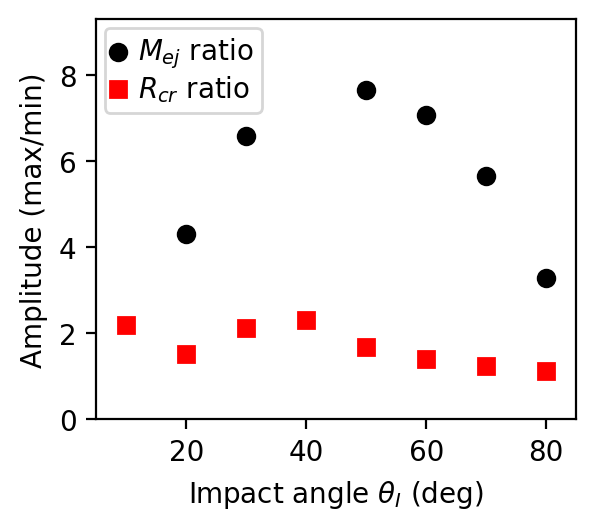

In [55]:
# Making an amplitude plot!
fig,ax = plt.subplots(1,1,figsize=(3,2.5),dpi=200,facecolor='white')
plt.subplots_adjust(hspace=0,wspace=0,right=0.98,left=0.18,top=0.98,bottom=0.18)

nang  = Maves_arr.shape[0]
M_ratio = np.zeros(nang)
tm = M_ratio*0
nang2  = rzero_2darr.shape[0]
R_ratio = np.zeros(nang2)
tm2 = R_ratio*0
for i in range(nang):
   
    tm[i] = mtheta_mesh[i,0]*180/np.pi
    #if (tm[i] != 40):
    M_ratio[i] = np.max(Maves_arr[i,:])/np.min(Maves_arr[i,:])  # ratio of max to min
    #else:
    #    M_ratio[i] = np.max(Maves_arr[i,:])/ Maves_arr[i,1]
    # I took max/min 
    # except for the crazy 40 degree one is off the plot altogether! 
        
for i in range(nang2):
    R_ratio[i] = np.max(rzero_2darr[i,:])/np.min(rzero_2darr[i,:])
    tm2[i] = theta_mesh[i,0]*180/np.pi
    
ax.plot(tm,M_ratio,'ko',label=r'$M_{ej}$ ratio')
ax.plot(tm2,R_ratio,'rs',label=r'$R_{cr}$ ratio')
ax.legend(borderpad=0.3,handlelength=0.4,handletextpad=0.5,columnspacing=0.7,\
          labelspacing=0.1,borderaxespad=0.3,handleheight=0.3,ncols=1,\
          loc = 'upper left')
ax.set_ylim(bottom=0,top=9.3)
ax.set_xlim(left=5,right=85)
ax.set_ylabel(r'Amplitude (max/min)')
ax.set_xlabel(r'Impact angle $\theta_I$ (deg)')
#axarr[0].legend(loc='best',borderpad=0.2,handlelength=0.4,handletextpad=0.1,columnspacing=1,labelspacing=0.15\
#               ,framealpha=0.9,borderaxespad=0.1,fontsize=11)

plt.savefig('Amplitudes.png',dpi=200)

In [38]:
M_ratio

array([ 3.28627451,  5.66483516,  7.08510638,  7.66666667, 36.13333333,
        6.58441558,  4.31746032])

In [143]:
# checking crater volumes here!!! 
# this was how I measured crater volume!
# measure crater volume (negative depth regions within a certain box of impact point)
def crater_volume(xmm,ymm,zmm,dleft,dright,dbottom,dtop):
    zsum=0.
    for i in range(len(xmm)):
        if (xmm[i]>dleft) and (xmm[i]<dright):
            for j in range(len(ymm)):
                if (ymm[j]>dbottom) and (ymm[j]<dtop):
                    if (zmm[j,i]<0):
                        zsum += zmm[j,i]
                        
    dxdy = (xmm[1]-xmm[0])*(ymm[1]-ymm[0])
    zsum *= dxdy  # result should be in mm^3
    return zsum


# relevant for rim uplift
# sum up volume for pixels above depth within radius1 and radius2
# only use pixels with sign given by pm
def crater_rad(xmm,ymm,zmm,radius1,radius2,pm):
    zsum=0.
    zsum2=0.
    for i in range(len(xmm)):
        for j in range(len(ymm)):
            xrad = np.sqrt(xmm[i]**2 + ymm[j]**2)
            if (xrad > radius1) and (xrad < radius2):
                if (pm == 'p') and (zmm[j,i]>0):
                    zsum += zmm[j,i]  # only positive counted 
                if (pm =='m') and (zmm[j,i]<0):
                    zsum += zmm[j,i]  # only negative neg counted
                    
    dxdy = (xmm[1]-xmm[0])*(ymm[1]-ymm[0])
    zsum *= np.abs(dxdy)  # result should be in mm^3
    
    return np.abs(zsum)
        

In [144]:
# checking crater volume of 80 degree impact angle crater 
i=80
fname = 'A' + '{:2d}'.format(i) + '_profile.npz'
j = int(i/10)-1
#print(fname,j)
xmm,ymm,zmm,slope,still_im = readnpz(fname)

vol = crater_volume(xmm,ymm,zmm,-35,35,-30,30) # in mm^3
print('MEASUREMENT')
print('vol = {:.2f} cm^3, mass {:.2f} g'.format(vol/1e3,vol*rho_a/1e6))
# not sure why this is slightly different from what we had before
# this is our new measurement for crater volume which we are probably going to use
# in the new paper

vol2 = crater_rad(xmm,ymm,zmm,10,50,'p')  # proxy for rim volume and mass 
print('vol2 = {:.2f} cm^3, mass {:.2f} g'.format(vol2/1e3,vol2*rho_a/1e6 ))
vol3 = crater_rad(xmm,ymm,zmm,30,50,'m') # small so irrelevant 
print('vol3 = {:.2f} cm^3, mass {:.2f} g'.format(vol3/1e3,vol3*rho_a/1e6 ))

# rim is about 1/4 of crater volume
# deformation could be about 1/2 of crater volume?
# since rim is 1/4 and uplift is mostly rim
# this implies that ejecta must be less than the rim volume
# our total of 5 g in eject is ok.  
# we conclude 

MEASUREMENT
vol = 13.84 cm^3, mass 20.75 g
vol2 = 3.37 cm^3, mass 5.05 g
vol3 = 0.18 cm^3, mass 0.27 g


In [ ]:
# below here not directly used in paper

In [6]:
# functions to make pi_V pi_R dimensionless numbers 
def pi_V_fun(K_1,K_2,mu,nu,pi_2,pi_3,pi_4):
    z1 = pi_2*np.power(pi_4,(6*nu - mu - 2.)/(3*mu))
    z2 = np.power(pi_3,(2+mu)/mu)*np.power(pi_4,(3*nu-1.)*(2.+mu)/(3*mu))
    pV = K_1*np.power(z1+K_2*z2,-3.0*mu/(2+mu))
    return pV

def pi_R_fun(K_R,K_2,mu,nu,pi_2,pi_3,pi_4):
    z1 = pi_2*np.power(pi_4,(6*nu - mu - 2.)/(3*mu))
    z2 = np.power(pi_3,(2+mu)/mu)*np.power(pi_4,(3*nu-1.)*(2.+mu)/(3*mu))
    pR = K_R*np.power(z1+K_2*z2,-mu/(2+mu))
    return pR

<IPython.core.display.Javascript object>


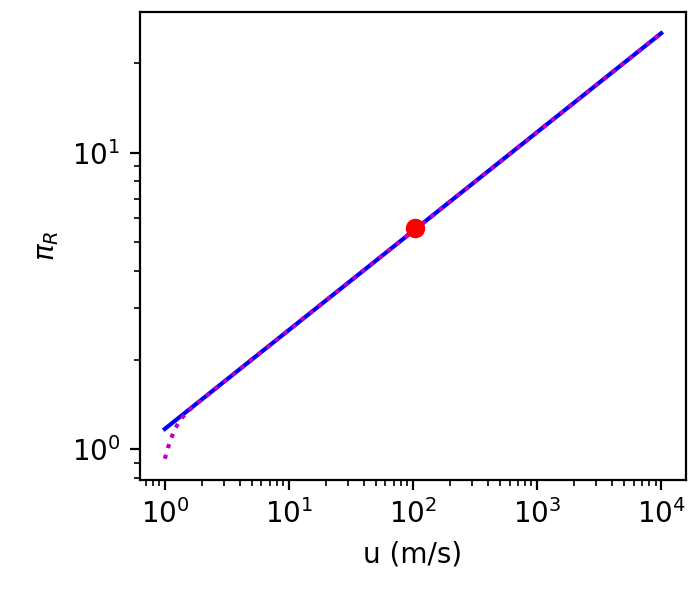

Text(0, 0.5, '$\\pi_R$')

In [7]:
# compare our experiment to predictions for pi_R
u_arr = np.logspace(0.0,4,100)
pi_2_arr = g_a*a_pj/u_arr**2
pi_3_arr_y2 = 100/(rho_a*u_arr**2)
pi_3_arr_yb = 1e3/(rho_a*u_arr**2)
K_R=0.65; K_2=1.0;  mu=0.4; nu=0.4; pi_4=1.0; 
pR_arr_y2 = pi_R_fun(K_R,K_2,mu,nu,pi_2_arr,pi_3_arr_y2,pi_4)
pR_arr_yb = pi_R_fun(K_R,K_2,mu,nu,pi_2_arr,pi_3_arr_yb,pi_4)

fig,ax = plt.subplots(1,1,figsize=(3.5,3),facecolor='white')
plt.subplots_adjust(left=0.2,top=0.98,bottom=0.2,right=0.98)
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(u_arr,pR_arr_y2,'b-')
ax.plot(u_arr,pR_arr_yb,'m:')
ax.plot(u_pj,pi_R_80,'ro')
#ax.set_xlabel(r'$\pi_2$ or $\pi_3$')
ax.set_xlabel(r'u (m/s)')
ax.set_ylabel(r'$\pi_R$')

# to get on the line we need K_R = 0.65, for K_R = 1 we are a bit low by a factor 
# of 0.65, we seem to be in gravity regime according to this. 
# this value of K_R is very sensitive to mu, if mu is 0.35 then K_R = 0.8


<IPython.core.display.Javascript object>


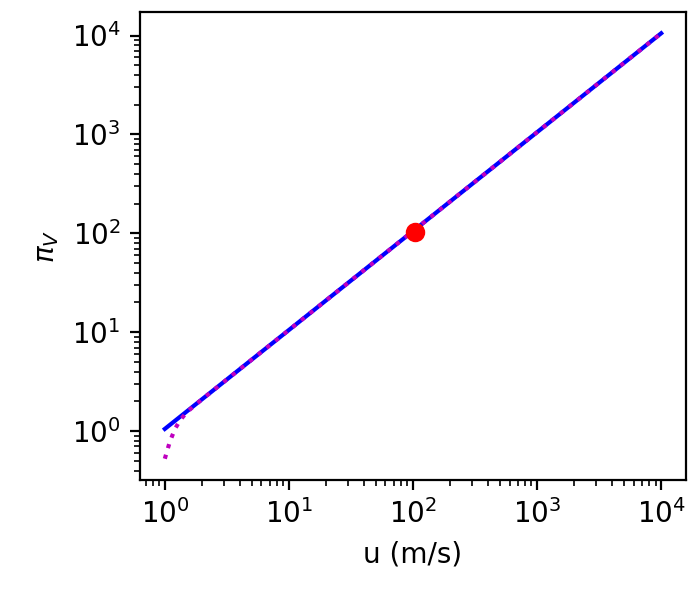

Text(0, 0.5, '$\\pi_V$')

In [8]:
# compare our experiments to predictions for pi_V
K_1 = 0.18; K_2=1.0; mu=0.4; nu=0.4; pi_4=1.0; 
pV_arr_y2 = pi_V_fun(K_1,K_2,mu,nu,pi_2_arr,pi_3_arr_y2,pi_4)
pV_arr_yb = pi_V_fun(K_1,K_2,mu,nu,pi_2_arr,pi_3_arr_yb,pi_4)

fig,ax = plt.subplots(1,1,figsize=(3.5,3),facecolor='white')
plt.subplots_adjust(left=0.2,top=0.98,bottom=0.2,right=0.98)
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(u_arr,pV_arr_y2,'b-')
ax.plot(u_arr,pV_arr_yb,'m:')
ax.plot(u_pj,pi_V_80,'ro')  #crater volume!
#ax.set_xlabel(r'$\pi_2$ or $\pi_3$')
ax.set_xlabel(r'u (m/s)')
ax.set_ylabel(r'$\pi_V$')

#For our data we need K_1 to be low 0.18

# This might be related to low $k_{crater}?$ compared to k for ejecta?

Ignoring porosity
and using Celik's formula which is also given in Holsapple+93, eqn 19
$$\pi_V = K_1 \left[ \pi_2 \pi_4^\frac{6\nu - \mu - 2}{3 \mu} 
               +  K_2 \pi_3^\frac{2 + \mu}{\mu} \pi_4^\frac{(3\nu-1)(2 + \mu)}{3\mu} \right]^{-\frac{3\mu}{2 + \mu}}$$
               
$$\pi_R = K_R \left[ \pi_2 \pi_4^\frac{6\nu - \mu - 2}{3 \mu} 
               +  K_2 \pi_3^\frac{2 + \mu}{\mu} \pi_4^\frac{(3\nu-1)(2 + \mu)}{3\mu} \right]^{-\frac{\mu}{2 + \mu}}$$



$$ M_{ej} = \rho_a k R_{cr}^3 $$

$$ M_{ej}(<x) = \rho_a k x^3 $$

$$dM_{ej} = \rho_a k 3 x^2 dx$$

$$ \left(\frac{v_{ej}}{v_{pj}} \right) = 
C_1 \left(\frac{x}{a_{pj}} \right)^{- \frac{1}{\mu}} \pi_4^{-\frac{\nu}{\mu}}
$$

A particle leaving the surface with velocity $v_{ej}$ will land a horizontal distance
$$x_d = x + \sin (2 \theta_{ej}) v_{ej}^2/g_a $$
where $\theta_{ej}$ is ejection angle. 
It stays in the air a time  after ejection 
$$ t_{max} = \sin\theta_{ej} v_{ej}/g_a$$

The trajectory
$$ x(t) = x + \cos \theta_{ej} v_{ej} t $$
$$ z(t) = \sin\theta_{ej} v_{ej}t - g_a t^2/2 $$

In [10]:


# get ejecta curtain information, normal impacts
# for looking at ejecta trajectories
# inputs:
#   input parms for ejecta: mu,nu,C_1,k,theta_ej, K_R,K_2
#   dimensionless parms pi_2,pi_3,pi_4
#   impact dimensions a_pj, m_pj, u_pj, rho_a, g_a
#   npts number of points in ejecta mass arrays
#   nrpts number of points in xratio arrays, not used 
#   xrmin,xrmax range for xland ratio array
# returns
#  xlin (units m), ejecta launch positions
#  xland (m), land positions
#  vej_arr m/s ejecta velocities
#  xratio_arr  xland/R_cr 
#  mratio_arr mass in ejecta per xratio bin in kg
#  mratio_carr cummulative mass in ejecta as a function of xratio
#  R_crn, crater radius , normal impact 
#  Mtotal, total ejecta mass in kg, normal impact 
def mkej(mu,nu,C_1,k,theta_ej,K_R,K_2,pi_2,pi_3,pi_4,a_pj,m_pj,u_pj,rho_a,g_a,\
         npts,nrpts,xr_min,xr_max):
    pi_R = pi_R_fun(K_R,K_2,mu,nu,pi_2,pi_3,pi_4)  # dimensionless pi_R
    rhofac = np.power(m_pj/rho_a,0.3333) # unit of length
    R_crn = pi_R*rhofac   # crater radius, normal impact 
    print('Rcrn {:.2f} cm'.format(R_crn*100))
    xlin = np.linspace(1.2*a_pj,R_crn,npts)  #ejecta source positions  in x 
    dx = xlin[1]-xlin[0]  # dx bin width 
    print('dx {:.2e} m'.format(dx))
    dM = rho_a*k*3*xlin**2*dx  # mass ejected from each x location 
    Mtotal = rho_a*k*R_crn**3  #total ejecta mass for a normal impact 
    print('M_ej_total {:.2f} g'.format(Mtotal*1000))

    vej_arr = u_pj*C_1*np.power(xlin/a_pj, -1.0/mu) * np.power(pi_4,-nu/mu)
    # velocity of ejecta at each x 
    xland = xlin + np.sin(2*theta_ej)*vej_arr**2/g_a # landing position 

    #xr_min = 0.8
    xratio_arr = np.linspace(xr_min,xr_max,100)  # restrict the range 
    # xratio is landing position divided by R_cr crater radius 
    dx_ratio = xratio_arr[1]- xratio_arr[0]
    #print('dx_ratio={:.2e}'.format(dx_ratio))
    mratio_arr = xratio_arr*0.0  # mass as a function of xratio

    # put landing mass in bins of xratio 
    for i in range(len(xland)):
        xratio = xland[i]/R_crn  # compute xratio = xland/Rcr
        xi = int((xratio - xr_min)/dx_ratio)  # index
        if ((xi < len(xratio_arr)) and (xi>=0)):
            mratio_arr[xi]+= dM[i]
    mratio_carr = np.cumsum(mratio_arr)  # cumulate M_ej, >x_land
     
    return xlin,xland,vej_arr,xratio_arr,mratio_arr,mratio_carr,R_crn,Mtotal
  
    


Rcrn 2.82 cm
dx 5.02e-04 m
M_ej_total 10.04 g


<IPython.core.display.Javascript object>


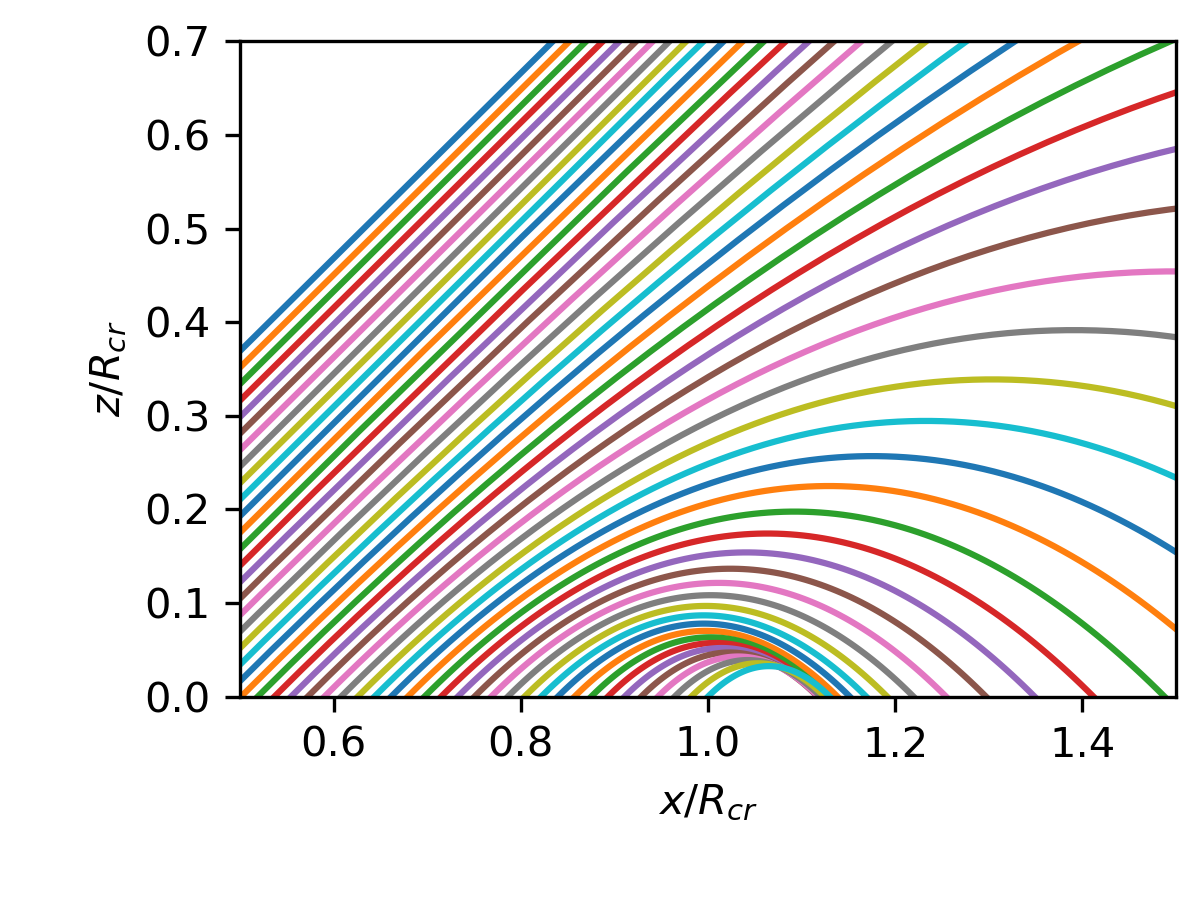

In [13]:
# crater scaling predicts trajectories for ejecta 
npts = 50
xlin,xland,vej_arr,xratio_arr,mratio_arr,mratio_carr,R_crn,Mtotal = \
    mkej(mu,nu,C_1,k,theta_ej,K_R,K_2,pi_2,pi_3,pi_4,a_pj,m_pj,u_pj,rho_a,g_a,\
         npts,nrpts,xr_min,xr_max)

xmax = 1.5

fig,ax = plt.subplots(figsize=(4,3),dpi=150,facecolor='white')
plt.subplots_adjust(bottom=0.2,top=0.98,left=0.2,right=0.98)
for i in range(npts):
    tmax = 2*vej_arr[i]*np.sin(theta_ej)/g_a
    tlin = np.linspace(0,tmax,100)
    zarr = (np.sin(theta_ej)*vej_arr[i]*tlin - g_a*tlin**2/2 )/R_crn
    xarr = (np.cos(theta_ej)*vej_arr[i]*tlin + xlin[i])/R_crn
    xmm = max(xarr)
    #if (xmm < xmax):
    ax.plot(xarr,zarr,'-')
    
ax.set_xlim([0.5,xmax])
ax.set_ylim([0.0,0.7])
ax.set_aspect('equal')
ax.set_xlabel(r'$x/R_{cr}$')
ax.set_ylabel(r'$z/R_{cr}$')
plt.savefig('trajs.png',dpi=150)

Rcrn 2.82 cm
dx 6.16e-05 m
M_ej_total 10.04 g


<IPython.core.display.Javascript object>


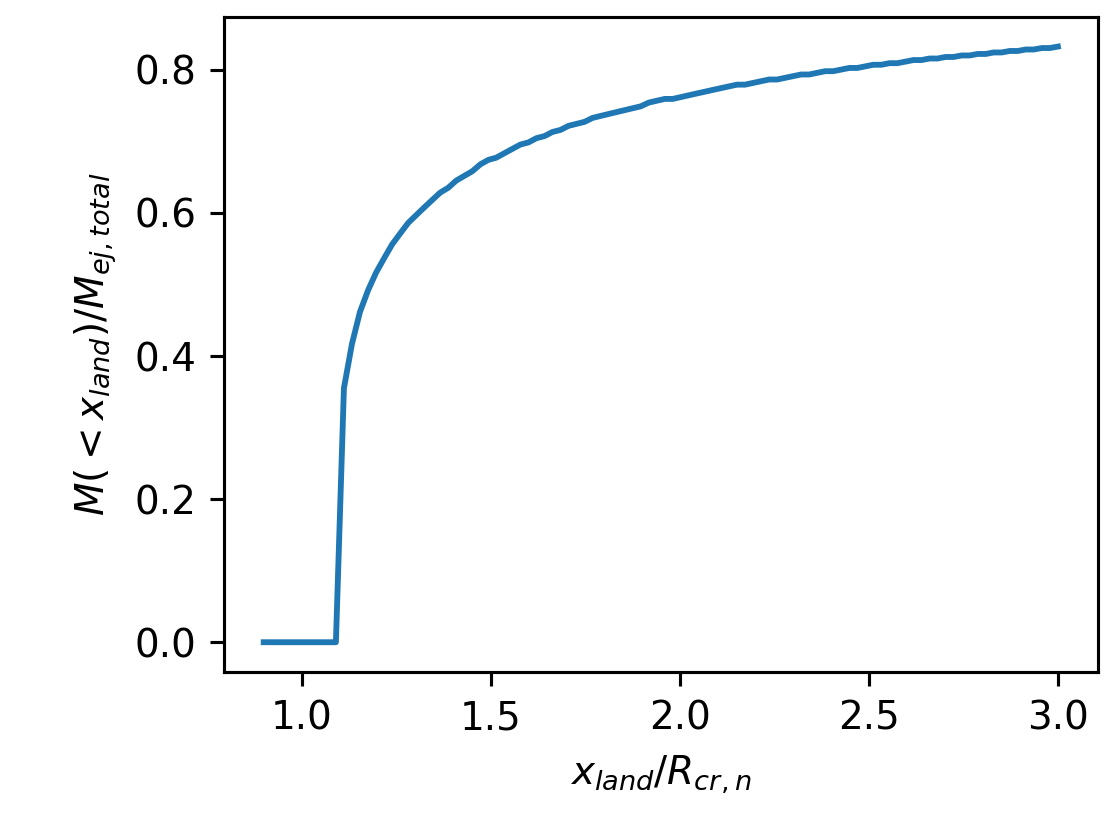

In [12]:
# check on what ejecta blanket distribution is predicted to look like 
mu = 0.4; nu=0.4; C_1=0.5; theta_ej = 45*np.pi/180; K_R =0.65; K_2=1; k=0.3
npts = 400; xr_min = 0.9; xr_max = 3;nrpts=1
xlin,xland,vej_arr,xratio_arr,mratio_arr,mratio_carr,R_crn,Mtotal = \
    mkej(mu,nu,C_1,k,theta_ej,K_R,K_2,pi_2,pi_3,pi_4,a_pj,m_pj,u_pj,rho_a,g_a,\
         npts,nrpts,xr_min,xr_max)

fig,ax = plt.subplots(figsize=(4,3),dpi=140,facecolor='white')
plt.subplots_adjust(bottom=0.2,top=0.98,left=0.2,right=0.98)
ax.plot(xratio_arr,mratio_carr/Mtotal,'-')
ax.set_xlabel(r'$x_{land}/R_{cr,n}$')
ax.set_ylabel(r'$M(<x_{land})/M_{ej,total}$')
#ax.set_xlabel('log10 x land/R_cr')
#ax.set_ylabel('dm')
plt.savefig('Mcum.png',dpi=150)

<IPython.core.display.Javascript object>


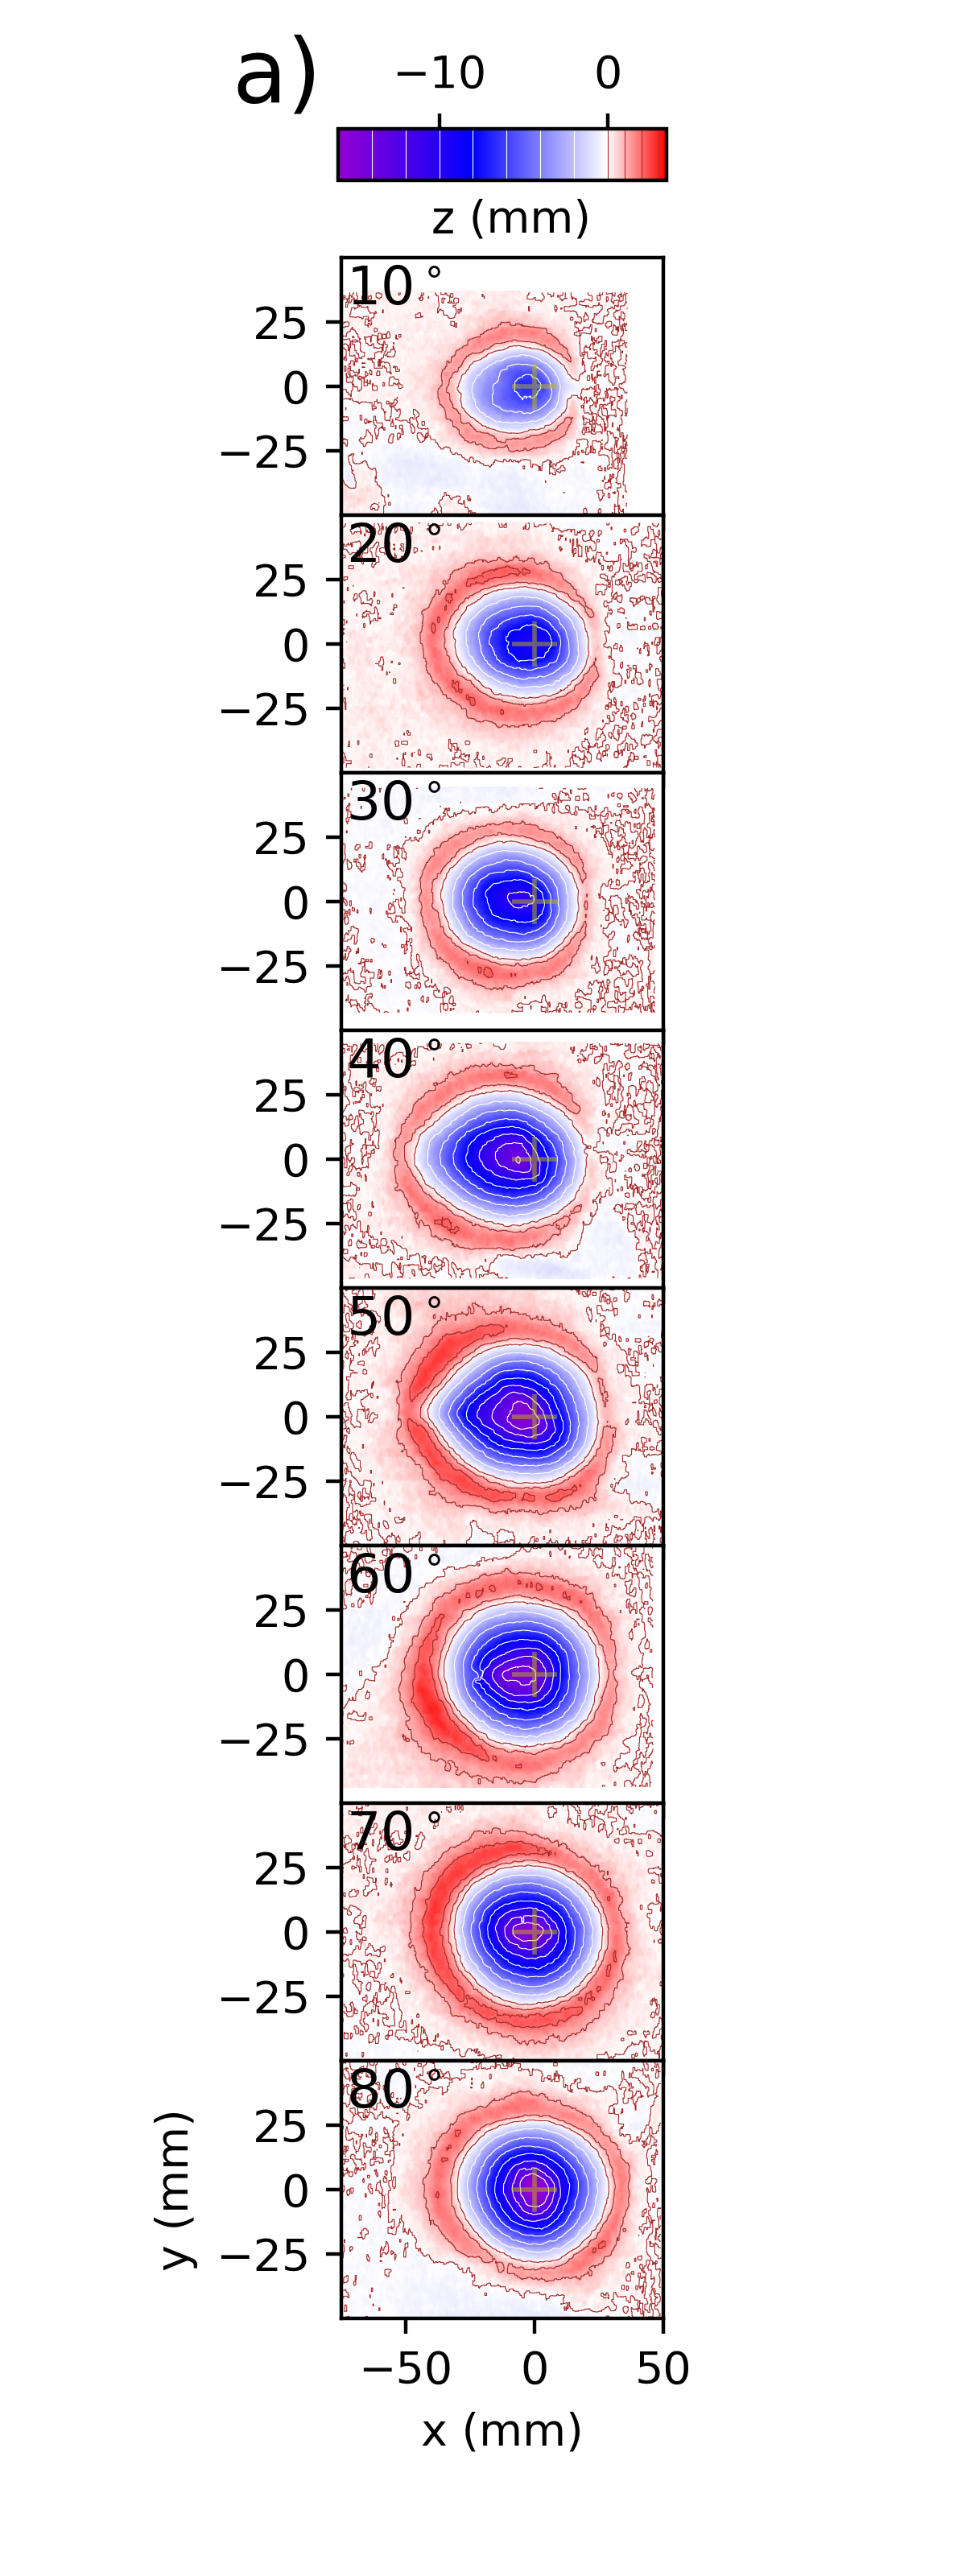

In [31]:
# from previous paper! Suo+24
fig,axarr = plt.subplots(8,1,figsize=(3,8),dpi=200,facecolor='white',sharex=True,sharey=True)
plt.subplots_adjust(bottom=0.10,top=0.90,left=0.05,right=0.99,hspace=0,wspace=0)
axarr[0].set_aspect(1.0)
x_winl, x_winr = -75,50
y_winl, y_winr = -50,50
axarr[0].set_xlim([x_winl,x_winr])
axarr[0].set_ylim([y_winl,y_winr])
axarr[0].set_yticks([-25,0,25])
axarr[7].set_ylabel('y (mm)')
axarr[7].set_xlabel('x (mm)')
for i in range(10,81,10):
    fname = 'A' + '{:2d}'.format(i) + '_profile.npz'
    j = int(i/10)-1
    #print(fname,j)
    xmm,ymm,zmm,slope,still_im = readnpz(fname)
    im,ccw=mkcmap(xmm,ymm,zmm,axarr[j],fname)
#cbar=plt.colorbar(im,ax = (axarr[0],axarr[1],axarr[2],axarr[3],axarr[4],axarr[5],axarr[6],axarr[7]),\
#                  shrink=0.4,anchor=(0.5, -0.0),pad=0.01,location='top',aspect=15) 

#cbar.set_label('z (mm)')
#cbar.add_lines(ccw)  

rect = 0.35, 0.93, 0.34,0.02
cax = fig.add_axes(rect)
cbar=plt.colorbar(im,cax=cax,ax = (axarr[0],axarr[1],axarr[2],axarr[3],axarr[4],axarr[5],axarr[6],axarr[7]),\
                  shrink=0.4,pad=0.01,aspect=15,panchor=False,orientation='horizontal',ticklocation='top' ) 
#,panchor=(1.0, 0.0) anchor=(0.5, -0.0), location='top',
#cbar.set_label('slope (deg)',loc='top')
axarr[0].text(-40,60,'z (mm)',fontsize=10)
cbar.add_lines(ccw)  
axarr[0].text(-100, 120,'a)',ha='center',va='center',fontsize=20)
#plt.savefig('A_contour.png',dpi=200)

<IPython.core.display.Javascript object>


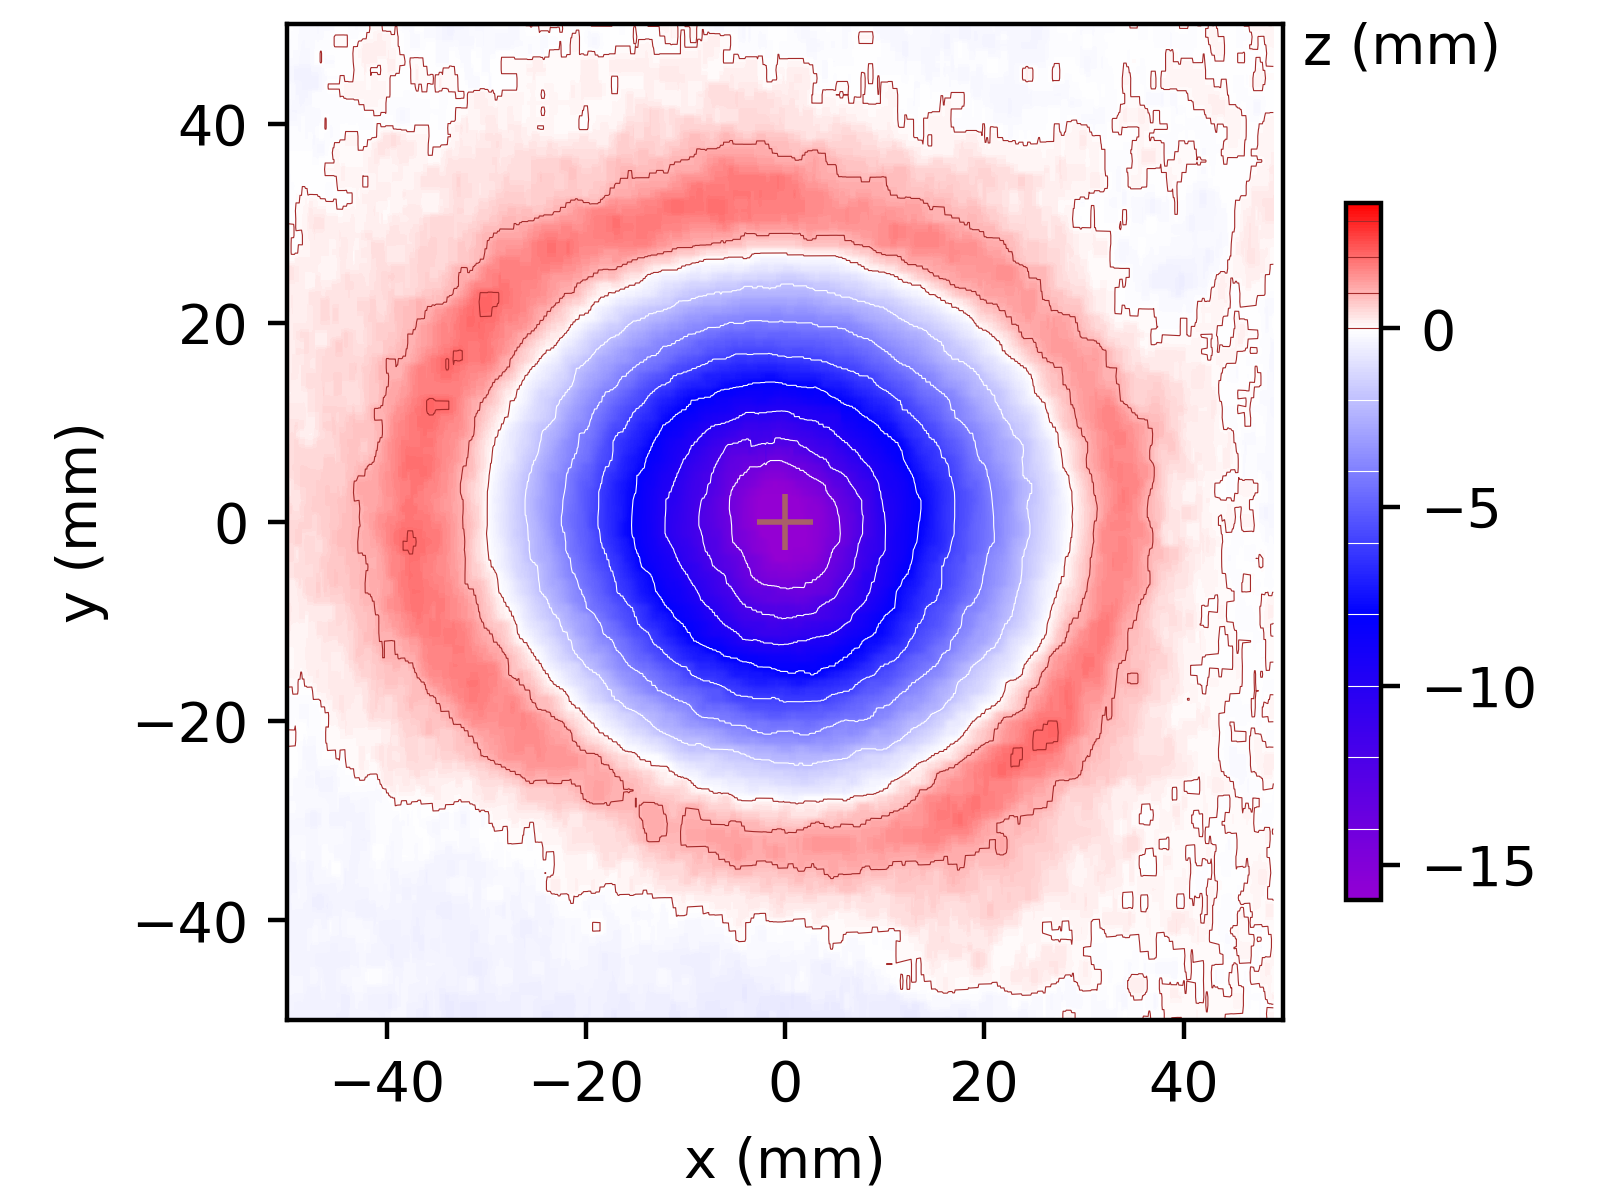

In [133]:
# make a nice figure of crater profile!
# I want to look at it as reference when trying to measure rim and crater volume
#from matplotlib.colors import ListedColormap, LinearSegmentedColormap
zmm_to_plot = zmm+0.0
extent = [np.min(xmm),np.max(xmm),np.min(ymm),np.max(ymm)]  # for x,y axes of plots
fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200,facecolor='white')
plt.subplots_adjust(bottom=0.15,top=0.98,left=0.17,right=0.96)
ax.set_aspect(1.0)

vmin,vmax=-16,3.5  # display range mm, these can be adjusted!
mcolors=['darkviolet','blue','white','red']
white_node = np.abs(vmin)/(vmax-vmin)
cyan_node  = np.abs(vmin/2)/(vmax-vmin)
nodes = [0.0, cyan_node,white_node,1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, mcolors)))
im=ax.imshow(zmm_to_plot,extent=extent,vmin=vmin,vmax=vmax,cmap=cmap2)
#levs = [-14,-12,-10,-8,-6,-4,-2,0,1,2]
levs = np.append(np.arange(-14,0,2),np.arange(0,4,1))
cols = []
for i in range(len(levs)):
    if (levs[i] <0):
        cols = np.append(cols,'white')
    else:
        cols = np.append(cols,'brown')

ccw=ax.contour(zmm_to_plot, extent=extent,levels=levs,colors=cols,linewidths=0.2,origin='upper')
cbar=plt.colorbar(im,shrink=0.7,anchor=(0.0, 0.4))
ax.text(52,46,'z (mm)')
cbar.add_lines(ccw)  # can only add one set of lines! set erase=False in order to do two sets!
x_winl=-50;x_winr=50
y_winl=-50;y_winr=50
ax.set_xlim([x_winl,x_winr])
ax.set_ylim([y_winl,y_winr])
ax.set_ylabel('y (mm)')
ax.set_xlabel('x (mm)')
ax.plot([0],[0],'y+',ms=10,lw=1,alpha=0.5)
#ii = np.argmin(zmm_filt)  # find deepest point!
#i,j=np.unravel_index(ii, zmm_filt.shape)
#ax.text(-70,40,froot[1:3]+r'$^\circ$',color='black',fontsize=14)
#plt.savefig(froot+'contour.png',dpi=200)


In [138]:
M_sol = 2e30  # in kg 
G = 6.67e-11  # kms
AU = 1.5e11 # m 
a_AU = 1

# density in Hill radius relevant for pebble cloud collapse
for i in range(3):
    a = a_AU*AU
    rho_H = (1.0/np.pi)*(3./2)**5 * M_sol/a**3   #eqn 2 by Polak&Klahr+22
    print('a_AU={:.1f}, rho_H={:.1e} kg/m^3'.format(a_AU,rho_H))
    a_AU*=10

a_AU=1.0, rho_H=1.4e-03 kg/m^3
a_AU=10.0, rho_H=1.4e-06 kg/m^3
a_AU=100.0, rho_H=1.4e-09 kg/m^3


In [164]:
# trying to guess at what Radican+22 was actually plotting in their figure 12 which makes no sense
# compute radius
def Rcr_Radu(theta_I,zeta,R_crn):
    Radu_ratio = -0.5*(1.0/100.0)*(180.0/np.pi)  # raducan function 
    a_11 = Radu_ratio*R_crn
    x = np.array([R_crn,a_11])
    return Rmod_Radu(x,theta_I,zeta)

# need to multiply by d zeta to get mass 
def k_fun_Radu(theta_I,zeta,k_n):
    return k_n*np.exp(-0.02*np.cos(zeta)*np.cos(theta_I))/(2*np.pi)


def mass_Radu(theta_I,theta,R_crn,k_n,dzeta):
    R = Rcr_Radu(theta_I,zeta,R_crn)
    k = k_fun_Radu(theta_I,zeta,k_n)
    dM = R**3 * k *dzeta
    return dM
    


<IPython.core.display.Javascript object>


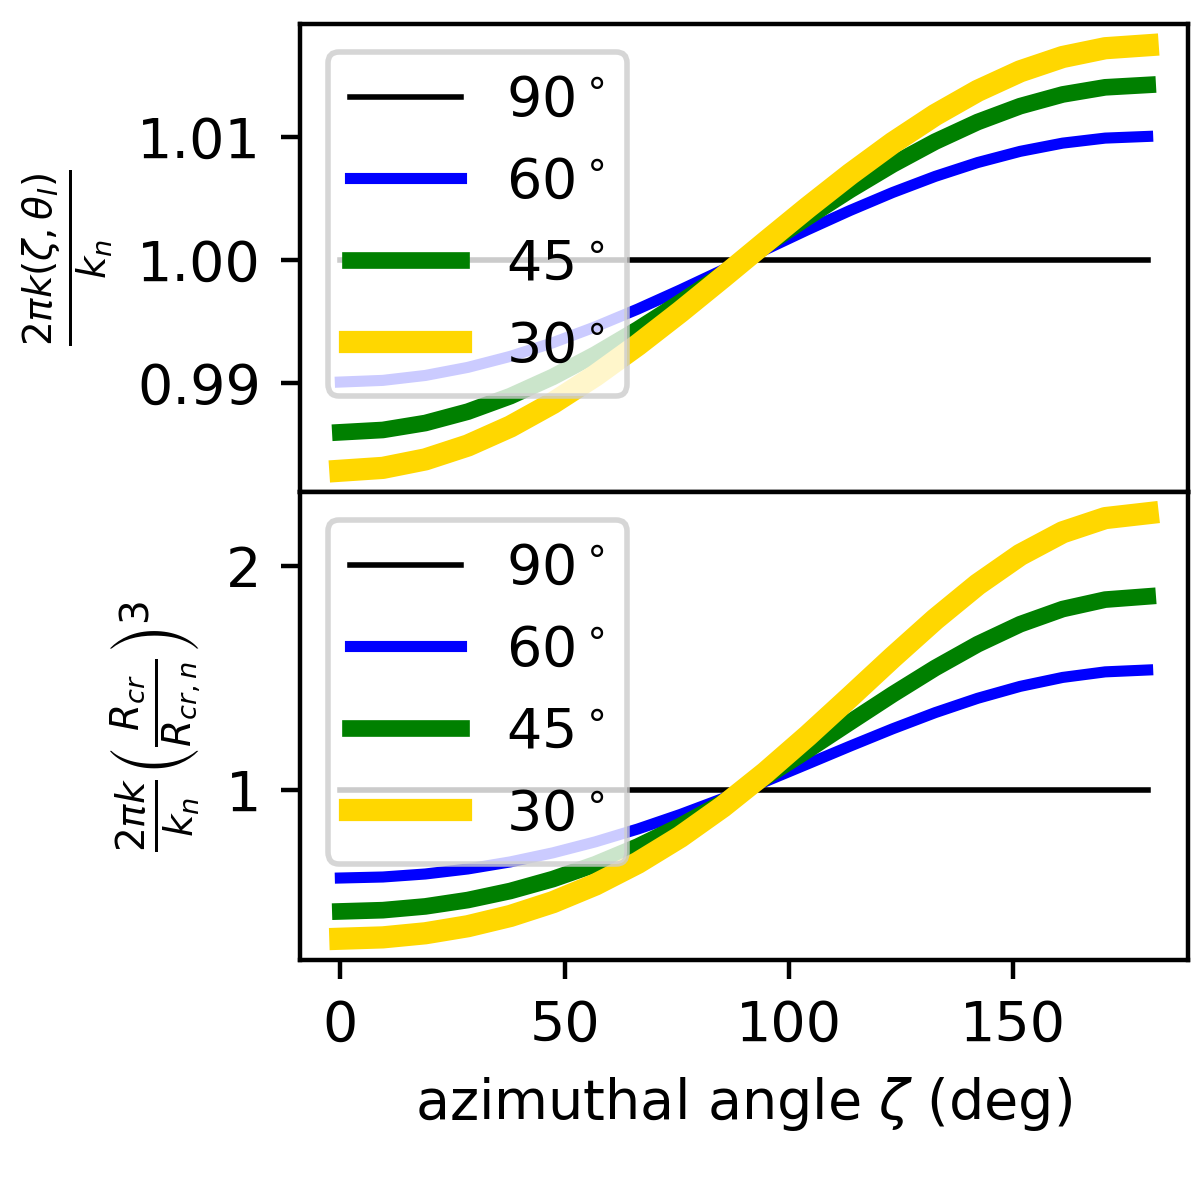

Text(0, 0.5, '$\\frac{2 \\pi k}{k_n} \\left( \\frac{ R_{cr}}{R_{cr,n}}\\right)^3$')

In [202]:
#WTF is Raducan+22 actually plotting?
zeta_lin = np.linspace(0,np.pi*1,20)
zeta_lin_deg = zeta_lin*180/np.pi
fig,axarr = plt.subplots(2,1,figsize=(3,3),dpi=200,sharex=True)
plt.subplots_adjust(left=0.25,right=0.99,top=0.98,bottom=0.2,hspace=0 )
theta_vals_deg = np.array([90,60,45,30])
theta_vals = theta_vals_deg*np.pi/180
k_n = 2*np.pi;  R_crn=1.0;
rcolorlist = ('black','blue','green','gold')
for i in range(len(theta_vals)):
    k_lin = k_fun_Radu(theta_vals[i],zeta_lin,k_n)
    axarr[0].plot(zeta_lin_deg,k_lin,'-',lw=i+1,label=r'{:d}$^\circ$'.format(\
                    theta_vals_deg[i]),color=rcolorlist[i])
    Rcr_lin = Rcr_Radu(theta_vals[i],zeta_lin,R_crn)
    m_lin = k_lin*Rcr_lin**3
    axarr[1].plot(zeta_lin_deg,m_lin,'-',lw=i+1,label=r'{:d}$^\circ$'.format(\
        theta_vals_deg[i]),color=rcolorlist[i])
axarr[0].legend()
axarr[1].legend()
axarr[0].set_ylabel(r'$\frac{2 \pi k(\zeta, \theta_I)}{k_n}$')
axarr[1].set_xlabel('azimuthal angle $\zeta$ (deg)')
axarr[1].set_ylabel(r'$\frac{2 \pi k}{k_n} \left( \frac{ R_{cr}}{R_{cr,n}}\right)^3$')
# compare this to Figure 

In [39]:
90+45

135